## Importing the Data

In [1]:
#TODO 分validation 
#方法1先分两部分, total training set + test set
#total training set 真正输入到cross validation function
#cross validation 中再划分training set和validation set 
#用找到的hyperparameter 训练
#方法2直接分成三部分
# Constants
#(TODO: cross validation, 得到最好模型, 用参数re training, 得到kappa score, 重复100次, 在test set上的kappa score
#2.增加additional features)
import warnings
warnings.filterwarnings("ignore") 

DATASET_DIR = './'
GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

import os
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
print(X.columns)
y = X["target_score"]
X = X.dropna(axis=1)
X = X.drop(['rater1_domain1', 'rater2_domain1'], axis=1)
essays = X['essay']




Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'essay_id', 'topic', 'essay', 'rater1_domain1',
       'rater2_domain1', 'rater3_domain1', 'target_score', 'rater1_domain2',
       'rater2_domain2', 'topic2_target', 'rater1_trait1', 'rater1_trait2',
       'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6',
       'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4',
       'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 'rater3_trait2',
       'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6',
       'err_ratio', 'avg_len', 'total_err_ratio', 'avg_wdlen', 'count_vector'],
      dtype='object')


In [2]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 14 columns):
Unnamed: 0            12976 non-null int64
Unnamed: 0.1          12976 non-null int64
Unnamed: 0.1.1        12976 non-null int64
Unnamed: 0.1.1.1      12976 non-null int64
Unnamed: 0.1.1.1.1    12976 non-null int64
essay_id              12976 non-null int64
topic                 12976 non-null int64
essay                 12976 non-null object
target_score          12976 non-null int64
err_ratio             12976 non-null object
avg_len               12976 non-null float64
total_err_ratio       12976 non-null float64
avg_wdlen             12976 non-null float64
count_vector          12976 non-null object
dtypes: float64(3), int64(8), object(3)
memory usage: 1.4+ MB


In [3]:
manually_features=['avg_len', 'total_err_ratio', 'avg_wdlen']

In [4]:
X['avg_len']=X['avg_len']/max(X['avg_len'])

In [5]:
X['total_err_ratio']=X['total_err_ratio']/max(X['total_err_ratio'])

In [6]:
X['avg_wdlen']=X['avg_wdlen']/max(X['avg_wdlen'])

Minimum and Maximum Scores for each essay set.

In [7]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

## Preprocessing the Data

We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [8]:
def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    #用np.append
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

## training Word2Vec model 

In [9]:
%%time
sentences = []

for essay in essays:
        # Obtaining all sentences from the training essays.
        sentences += essay_to_sentences(essay, remove_stopwords = True)

# Initializing variables for word2vec model.
num_features = 300
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

print("Training Word2Vec Model...")
model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

model.init_sims(replace=True)
model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)
# Generate word vectors.
word_list = []

for essay in essays:
    word_list.append(essay_to_wordlist(essay, remove_stopwords=True))
word_vec = getAvgFeatureVecs(word_list, model, num_features)
print(word_vec)
wv=word_vec.copy()#used for analyze feature importances

Training Word2Vec Model...
[[-1.8716221e-03  1.2932693e-02 -2.0040851e-02 ... -1.1145740e-02
   7.2081573e-03  3.1488549e-02]
 [ 1.5186748e-02  2.2789836e-02 -1.4946913e-02 ... -7.9027917e-03
   1.1729123e-02  1.7719567e-02]
 [ 1.6506486e-02  1.8427793e-02 -1.6984005e-02 ... -1.0465873e-02
   6.2510492e-03  1.8419728e-02]
 ...
 [-9.3211690e-03  1.4803529e-02 -8.5349288e-04 ... -1.6117213e-02
   7.0615369e-03  3.5541527e-02]
 [-7.7142045e-03  1.5485279e-02 -1.2767538e-02 ... -8.3621964e-03
  -1.1245784e-03  2.4529912e-02]
 [ 5.7827804e-04  5.6791659e-03 -1.6148731e-02 ... -2.1567669e-02
   4.8311285e-05  2.4277810e-02]]
Wall time: 1min 25s


In [10]:
print(type(word_vec))

<class 'numpy.ndarray'>


In [11]:
manually_features=['avg_len', 'total_err_ratio', 'avg_wdlen']*10
for i in manually_features:
    matrix = np.array(X[i]).reshape(len(X[i]), 1)
    word_vec=np.hstack((matrix, np.array(word_vec)))

In [12]:
print(word_vec.shape)#TODO

(12976, 330)


## split dataset

In [13]:
from sklearn.model_selection import train_test_split
X_train_validation, X_test, y_train_validation, y_test = train_test_split(word_vec, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.2, random_state=42)

In [14]:
print(np.array(word_vec).shape)
print(np.array(X_train).shape)
print(np.array(X_validation).shape)
print(np.array(X_test).shape)

(12976, 330)
(8304, 330)
(2076, 330)
(2596, 330)


## Defining the model 

Here we define a 2-Layer LSTM Model. 

Note that instead of using sigmoid activation in the output layer we will use
Relu since we are not normalising training labels.

In [15]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from numpy.random import rand
# Import HyperOpt Library
from hyperopt import tpe, hp, fmin
def get_model(hidden_units_1, hidden_units_2, dropout_rate,num_features):
        """Define the model."""
        model = Sequential()
        model.add(LSTM(hidden_units_1, dropout=dropout_rate, recurrent_dropout=0.4, input_shape=[1, num_features], return_sequences=True))
        model.add(LSTM(hidden_units_2, recurrent_dropout=0.4))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='relu'))

        model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
        model.summary()

        return model
   


Using TensorFlow backend.


### tuning hyper parameters:

1.hidden units in 2 units, first:100-1000, s=10 second:20-500, s=10
2.dropout rates:randomly choose from 0-0.99
3.batch_size=16,32,64,128,256, 
4.epochs=1-10.step=1

In [16]:
def train_LSTM_model_for_tuning(params):
    hidden_units_1, hidden_units_2, dropout_rate, batch_size, epochs = params['hidden_units_1'],params['hidden_units_2'], params['dropout_rate'],params['batch_size'], params['epochs']
    

    results = []
    y_pred_list = []

    count = 1
    
    trainDataVecs = np.array(X_train)
    validationDataVecs = np.array(X_validation)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    validationDataVecs = np.reshape(validationDataVecs, (validationDataVecs.shape[0], 1, validationDataVecs.shape[1]))

    lstm_model = get_model(hidden_units_1, hidden_units_2, dropout_rate,num_features+30)#TODO更改num_features
    lstm_model.fit(trainDataVecs, y_train, batch_size=batch_size, epochs=epochs)
    #epochs 太大容易overfit
    #lstm_model.load_weights('./model_weights/final_lstm.h5')
    y_pred = lstm_model.predict(validationDataVecs)

    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)

    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_validation,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    return result

ep = np.arange(1,11,1)

space = {
    #'num_features': hp.choice('num_features',np.arange(100,3001,100)),
    'hidden_units_1': hp.choice('hidden_units_1',np.arange(100,1001,10)),
    'hidden_units_2': hp.choice('hidden_units_2',np.arange(20,501,10)),
    'dropout_rate': hp.choice('dropout_rate',rand(10)),
    'batch_size': hp.choice('batch_size',[16,32,64,128,256]),
    'epochs': hp.choice('epochs',np.arange(1,11,1)),
}
best = fmin(
    fn=train_LSTM_model_for_tuning, # Objective Function to optimize
    space=space, # Hyperparameter's Search Space
    algo=tpe.suggest, # Optimization algorithm (representative TPE)
    max_evals=10 # Number of optimization attempts
)
print(best)

Model: "sequential_1"                                 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 670)            2682680   
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                240320    
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 81        
Total params: 2,923,081                               
Trainable params: 2,923,081                           
Non-trainable params: 0                               
_________________________________________________________________
  0%|          | 0/10 [00:01<?, ?trial/s, best loss=?]WARNING:tensorflow:From C:\ProgramData\Anaconda3\lib\site-packages

                                                     
2432/8304 [=======>......................]            
 - ETA: 1s - loss: 50.5786 - mae: 3.8177              
                                                     
2688/8304 [========>.....................]            
 - ETA: 1s - loss: 50.7713 - mae: 3.8260              
                                                     
2944/8304 [=========>....................]            
 - ETA: 1s - loss: 50.5923 - mae: 3.8071              
                                                     
3200/8304 [==========>...................]            
 - ETA: 1s - loss: 50.1285 - mae: 3.7962              
                                                     
3456/8304 [===========>..................]            
 - ETA: 1s - loss: 48.9498 - mae: 3.7603              
                                                     
3712/8304 [============>.................]            
 - ETA: 1s - loss: 48.1684 - mae: 3.7428              
                

 - ETA: 0s - loss: 37.0837 - mae: 3.4705              
                                                     
6528/8304 [======================>.......]            
 - ETA: 0s - loss: 37.2789 - mae: 3.4849              
                                                     
6784/8304 [=======================>......]            
 - ETA: 0s - loss: 37.1303 - mae: 3.4724              
                                                     
7040/8304 [========================>.....]            
 - ETA: 0s - loss: 36.6963 - mae: 3.4549              
                                                     
7296/8304 [=========================>....]            
 - ETA: 0s - loss: 36.9960 - mae: 3.4549              
                                                     
7552/8304 [==========================>...]            
 - ETA: 0s - loss: 36.9219 - mae: 3.4501              
                                                     
7808/8304 [===========================>..]            
 - ETA: 0s - los

2176/8304 [======>.......................]            
 - ETA: 1s - loss: 25.1627 - mae: 2.6837              
                                                     
2432/8304 [=======>......................]            
 - ETA: 1s - loss: 25.6545 - mae: 2.7114              
                                                     
2688/8304 [========>.....................]            
 - ETA: 1s - loss: 25.9812 - mae: 2.7345              
                                                     
2944/8304 [=========>....................]            
 - ETA: 1s - loss: 26.1086 - mae: 2.7368              
                                                     
3200/8304 [==========>...................]            
 - ETA: 1s - loss: 25.6905 - mae: 2.7189              
                                                     
3456/8304 [===========>..................]            
 - ETA: 1s - loss: 26.4647 - mae: 2.7399              
                                                     
3712/8304 [=====

                                                     
6016/8304 [====================>.........]            
 - ETA: 0s - loss: 24.8255 - mae: 2.6961              
                                                     
6272/8304 [=====================>........]            
 - ETA: 0s - loss: 24.8462 - mae: 2.6946              
                                                     
6528/8304 [======================>.......]            
 - ETA: 0s - loss: 24.6373 - mae: 2.6814              
                                                     
6784/8304 [=======================>......]            
 - ETA: 0s - loss: 24.4597 - mae: 2.6678              
                                                     
7040/8304 [========================>.....]            
 - ETA: 0s - loss: 24.3680 - mae: 2.6678              
                                                     
7296/8304 [=========================>....]            
 - ETA: 0s - loss: 24.3231 - mae: 2.6708              
                

1376/8304 [===>..........................]                                      
 - ETA: 11s - loss: 77.6629 - mae: 5.0176                                       
                                                                                
1440/8304 [====>.........................]                                      
 - ETA: 11s - loss: 76.8812 - mae: 4.9886                                       
                                                                                
1504/8304 [====>.........................]                                      
 - ETA: 11s - loss: 77.0613 - mae: 5.0087                                       
                                                                                
1568/8304 [====>.........................]                                      
 - ETA: 11s - loss: 77.7866 - mae: 5.0220                                       
                                                                                
1632/8304 [====>............

                                                                               
3552/8304 [===========>..................]                                      
 - ETA: 6s - loss: 70.0274 - mae: 4.6154                                        
                                                                               
3616/8304 [============>.................]                                      
 - ETA: 6s - loss: 70.2826 - mae: 4.6214                                        
                                                                               
3680/8304 [============>.................]                                      
 - ETA: 6s - loss: 70.4444 - mae: 4.6309                                        
                                                                               
3744/8304 [============>.................]                                      
 - ETA: 6s - loss: 69.7790 - mae: 4.6106                                        
                                

 - ETA: 3s - loss: 64.7305 - mae: 4.3978                                        
                                                                               
5728/8304 [===================>..........]                                      
 - ETA: 3s - loss: 64.6957 - mae: 4.3972                                        
                                                                               
5792/8304 [===================>..........]                                      
 - ETA: 3s - loss: 64.5974 - mae: 4.3931                                        
                                                                               
5856/8304 [====================>.........]                                      
 - ETA: 3s - loss: 64.4519 - mae: 4.3846                                        
                                                                               
5920/8304 [====================>.........]                                      
 - ETA: 3s - loss: 64.3332 - mae

7840/8304 [===========================>..]                                      
 - ETA: 0s - loss: 59.5476 - mae: 4.1469                                        
                                                                               
7904/8304 [===========================>..]                                      
 - ETA: 0s - loss: 59.2710 - mae: 4.1345                                        
                                                                               
7968/8304 [===========================>..]                                      
 - ETA: 0s - loss: 58.9026 - mae: 4.1214                                        
                                                                               
8032/8304 [============================>.]                                      
 - ETA: 0s - loss: 58.7274 - mae: 4.1132                                        
                                                                               
8096/8304 [=====================

                                                                               
1632/8304 [====>.........................]                                      
 - ETA: 8s - loss: 32.5950 - mae: 2.8846                                        
                                                                               
1696/8304 [=====>........................]                                      
 - ETA: 8s - loss: 32.6399 - mae: 2.8954                                        
                                                                               
1760/8304 [=====>........................]                                      
 - ETA: 8s - loss: 33.0549 - mae: 2.9245                                        
                                                                               
1824/8304 [=====>........................]                                      
 - ETA: 7s - loss: 34.0257 - mae: 2.9575                                        
                                

 - ETA: 5s - loss: 34.8874 - mae: 2.9828                                        
                                                                               
3776/8304 [============>.................]                                      
 - ETA: 5s - loss: 34.9445 - mae: 2.9856                                        
                                                                               
3840/8304 [============>.................]                                      
 - ETA: 5s - loss: 34.5864 - mae: 2.9716                                        
                                                                               
3904/8304 [=============>................]                                      
 - ETA: 5s - loss: 34.7271 - mae: 2.9822                                        
                                                                               
3968/8304 [=============>................]                                      
 - ETA: 5s - loss: 34.4211 - mae

5888/8304 [====================>.........]                                      
 - ETA: 2s - loss: 34.6356 - mae: 2.9652                                        
                                                                               
5952/8304 [====================>.........]                                      
 - ETA: 2s - loss: 34.8534 - mae: 2.9735                                        
                                                                               
6016/8304 [====================>.........]                                      
 - ETA: 2s - loss: 34.7947 - mae: 2.9715                                        
                                                                               
6080/8304 [====================>.........]                                      
 - ETA: 2s - loss: 35.0822 - mae: 2.9818                                        
                                                                               
6144/8304 [=====================

                                                                               
8064/8304 [============================>.]                                      
 - ETA: 0s - loss: 34.8457 - mae: 2.9696                                        
                                                                               
8128/8304 [============================>.]                                      
 - ETA: 0s - loss: 34.8415 - mae: 2.9686                                        
                                                                               
8192/8304 [============================>.]                                      
 - ETA: 0s - loss: 34.7324 - mae: 2.9646                                        
                                                                               
8256/8304 [============================>.]                                      
 - ETA: 0s - loss: 34.8845 - mae: 2.9716                                        
                                

 - ETA: 7s - loss: 28.8176 - mae: 2.7621                                        
                                                                               
1888/8304 [=====>........................]                                      
 - ETA: 7s - loss: 28.7299 - mae: 2.7685                                        
                                                                               
1952/8304 [======>.......................]                                      
 - ETA: 7s - loss: 28.5071 - mae: 2.7617                                        
                                                                               
2016/8304 [======>.......................]                                      
 - ETA: 7s - loss: 28.8409 - mae: 2.7795                                        
                                                                               
2080/8304 [======>.......................]                                      
 - ETA: 7s - loss: 28.8999 - mae

4000/8304 [=============>................]                                      
 - ETA: 5s - loss: 29.3119 - mae: 2.8034                                        
                                                                               
4064/8304 [=============>................]                                      
 - ETA: 5s - loss: 29.0590 - mae: 2.7954                                        
                                                                               
4128/8304 [=============>................]                                      
 - ETA: 5s - loss: 28.9495 - mae: 2.7922                                        
                                                                               
4192/8304 [==============>...............]                                      
 - ETA: 5s - loss: 29.0762 - mae: 2.7897                                        
                                                                               
4256/8304 [==============>......

                                                                               
6176/8304 [=====================>........]                                      
 - ETA: 2s - loss: 28.5798 - mae: 2.7615                                        
                                                                               
6240/8304 [=====================>........]                                      
 - ETA: 2s - loss: 28.5121 - mae: 2.7614                                        
                                                                               
6304/8304 [=====================>........]                                      
 - ETA: 2s - loss: 28.9231 - mae: 2.7709                                        
                                                                               
6368/8304 [======================>.......]                                      
 - ETA: 2s - loss: 28.9593 - mae: 2.7746                                        
                                

 - ETA: 0s - loss: 28.1653 - mae: 2.7483                                        
                                                                               
8304/8304 [==============================]                                      
 - 10s 1ms/step - loss: 28.1649 - mae: 2.7491                                   

Kappa Score: 0.8075499100959453                                                 
Model: "sequential_3"                                                           
_________________________________________________________________               
Layer (type)                 Output Shape              Param #                  
lstm_5 (LSTM)                (None, 1, 740)            3170160                  
_________________________________________________________________               
lstm_6 (LSTM)                (None, 230)               893320                   
_________________________________________________________________               
dropout_3 (Dropout)         

 - ETA: 2s - loss: 74.8492 - mae: 5.1025                                        
                                                                               
3584/8304 [===========>..................]                                      
 - ETA: 2s - loss: 73.3327 - mae: 5.0361                                        
                                                                               
3712/8304 [============>.................]                                      
 - ETA: 2s - loss: 73.0671 - mae: 5.0105                                        
                                                                               
3840/8304 [============>.................]                                      
 - ETA: 2s - loss: 72.6328 - mae: 4.9910                                        
                                                                               
3968/8304 [=============>................]                                      
 - ETA: 2s - loss: 72.5229 - mae

7808/8304 [===========================>..]                                      
 - ETA: 0s - loss: 59.8712 - mae: 4.4561                                        
                                                                               
7936/8304 [===========================>..]                                      
 - ETA: 0s - loss: 60.0790 - mae: 4.4615                                        
                                                                               
8064/8304 [============================>.]                                      
 - ETA: 0s - loss: 59.8110 - mae: 4.4556                                        
                                                                               
8192/8304 [============================>.]                                      
 - ETA: 0s - loss: 59.1406 - mae: 4.4291                                        
                                                                               
8304/8304 [=====================

                                                                               
3840/8304 [============>.................]                                      
 - ETA: 1s - loss: 37.0476 - mae: 3.6667                                        
                                                                               
3968/8304 [=============>................]                                      
 - ETA: 1s - loss: 37.4159 - mae: 3.6795                                        
                                                                               
4096/8304 [=============>................]                                      
 - ETA: 1s - loss: 36.9389 - mae: 3.6564                                        
                                                                               
4224/8304 [==============>...............]                                      
 - ETA: 1s - loss: 36.9129 - mae: 3.6621                                        
                                

 - ETA: 0s - loss: 36.6881 - mae: 3.7218                                        
                                                                               
8192/8304 [============================>.]                                      
 - ETA: 0s - loss: 36.5381 - mae: 3.7134                                        
                                                                               
8304/8304 [==============================]                                      
 - 4s 433us/step - loss: 36.3972 - mae: 3.7096                                  

Epoch 3/10                                                                      
 128/8304 [..............................]                                      
 - ETA: 2s - loss: 46.8204 - mae: 4.0400                                        
                                                                               
 384/8304 [>.............................]                                      
 - ETA: 2s - loss: 40.4179 - m

4352/8304 [==============>...............]                                      
 - ETA: 1s - loss: 33.6743 - mae: 3.7216                                        
                                                                               
4480/8304 [===============>..............]                                      
 - ETA: 1s - loss: 33.5714 - mae: 3.7140                                        
                                                                               
4608/8304 [===============>..............]                                      
 - ETA: 1s - loss: 33.6366 - mae: 3.7158                                        
                                                                               
4736/8304 [================>.............]                                      
 - ETA: 1s - loss: 33.7453 - mae: 3.7244                                        
                                                                               
4864/8304 [================>....

                                                                               
 640/8304 [=>............................]                                      
 - ETA: 2s - loss: 33.9305 - mae: 3.6807                                        
                                                                               
 768/8304 [=>............................]                                      
 - ETA: 2s - loss: 34.0510 - mae: 3.7650                                        
                                                                               
 896/8304 [==>...........................]                                      
 - ETA: 2s - loss: 35.0213 - mae: 3.8113                                        
                                                                               
1024/8304 [==>...........................]                                      
 - ETA: 2s - loss: 33.5857 - mae: 3.7651                                        
                                

 - ETA: 1s - loss: 30.8141 - mae: 3.5870                                        
                                                                               
5248/8304 [=================>............]                                      
 - ETA: 1s - loss: 30.7585 - mae: 3.5826                                        
                                                                               
5376/8304 [==================>...........]                                      
 - ETA: 1s - loss: 30.7979 - mae: 3.5868                                        
                                                                               
5632/8304 [===================>..........]                                      
 - ETA: 1s - loss: 30.8876 - mae: 3.5822                                        
                                                                               
5888/8304 [====================>.........]                                      
 - ETA: 0s - loss: 30.8067 - mae

1920/8304 [=====>........................]                                      
 - ETA: 2s - loss: 28.6113 - mae: 3.3374                                        
                                                                               
2048/8304 [======>.......................]                                      
 - ETA: 2s - loss: 28.4822 - mae: 3.3475                                        
                                                                               
2176/8304 [======>.......................]                                      
 - ETA: 2s - loss: 28.1950 - mae: 3.3261                                        
                                                                               
2304/8304 [=======>......................]                                      
 - ETA: 2s - loss: 27.3842 - mae: 3.2852                                        
                                                                               
2560/8304 [========>............

                                                                               
6656/8304 [=======================>......]                                      
 - ETA: 0s - loss: 28.4019 - mae: 3.2956                                        
                                                                               
6784/8304 [=======================>......]                                      
 - ETA: 0s - loss: 28.5690 - mae: 3.3032                                        
                                                                               
6912/8304 [=======================>......]                                      
 - ETA: 0s - loss: 28.4798 - mae: 3.3014                                        
                                                                               
7040/8304 [========================>.....]                                      
 - ETA: 0s - loss: 28.2896 - mae: 3.2932                                        
                                

 - ETA: 2s - loss: 27.2055 - mae: 3.1473                                        
                                                                               
3200/8304 [==========>...................]                                      
 - ETA: 2s - loss: 27.6577 - mae: 3.1546                                        
                                                                               
3456/8304 [===========>..................]                                      
 - ETA: 1s - loss: 27.2660 - mae: 3.1365                                        
                                                                               
3584/8304 [===========>..................]                                      
 - ETA: 1s - loss: 27.6299 - mae: 3.1488                                        
                                                                               
3712/8304 [============>.................]                                      
 - ETA: 1s - loss: 27.8275 - mae

8192/8304 [============================>.]                                      
 - ETA: 0s - loss: 25.2970 - mae: 2.9876                                        
                                                                               
8304/8304 [==============================]                                      
 - 3s 402us/step - loss: 25.3099 - mae: 2.9875                                  

Epoch 7/10                                                                      
 128/8304 [..............................]                                      
 - ETA: 2s - loss: 43.8496 - mae: 4.0803                                        
                                                                               
 256/8304 [..............................]                                      
 - ETA: 3s - loss: 32.4051 - mae: 3.5102                                        
                                                                               
 384/8304 [>..................

                                                                               
4224/8304 [==============>...............]                                      
 - ETA: 1s - loss: 26.1085 - mae: 3.0230                                        
                                                                               
4352/8304 [==============>...............]                                      
 - ETA: 1s - loss: 25.8281 - mae: 3.0121                                        
                                                                               
4480/8304 [===============>..............]                                      
 - ETA: 1s - loss: 25.9960 - mae: 3.0098                                        
                                                                               
4608/8304 [===============>..............]                                      
 - ETA: 1s - loss: 25.7757 - mae: 2.9998                                        
                                

 - ETA: 2s - loss: 17.8581 - mae: 2.6217                                        
                                                                               
 256/8304 [..............................]                                      
 - ETA: 2s - loss: 24.7414 - mae: 3.0499                                        
                                                                               
 384/8304 [>.............................]                                      
 - ETA: 3s - loss: 25.7458 - mae: 3.0156                                        
                                                                               
 512/8304 [>.............................]                                      
 - ETA: 3s - loss: 24.9950 - mae: 2.9268                                        
                                                                               
 640/8304 [=>............................]                                      
 - ETA: 3s - loss: 25.0760 - mae

4608/8304 [===============>..............]                                      
 - ETA: 1s - loss: 24.5145 - mae: 2.9021                                        
                                                                               
4736/8304 [================>.............]                                      
 - ETA: 1s - loss: 24.2732 - mae: 2.8923                                        
                                                                               
4864/8304 [================>.............]                                      
 - ETA: 1s - loss: 24.2612 - mae: 2.8956                                        
                                                                               
4992/8304 [=================>............]                                      
 - ETA: 1s - loss: 24.2855 - mae: 2.8962                                        
                                                                               
5120/8304 [=================>...

                                                                               
1024/8304 [==>...........................]                                      
 - ETA: 2s - loss: 25.3746 - mae: 2.9172                                        
                                                                               
1152/8304 [===>..........................]                                      
 - ETA: 2s - loss: 25.2963 - mae: 2.9070                                        
                                                                               
1280/8304 [===>..........................]                                      
 - ETA: 2s - loss: 25.3559 - mae: 2.9177                                        
                                                                               
1408/8304 [====>.........................]                                      
 - ETA: 2s - loss: 24.8606 - mae: 2.8791                                        
                                

 - ETA: 1s - loss: 23.3613 - mae: 2.7707                                        
                                                                               
5888/8304 [====================>.........]                                      
 - ETA: 0s - loss: 23.3371 - mae: 2.7742                                        
                                                                               
6016/8304 [====================>.........]                                      
 - ETA: 0s - loss: 23.3499 - mae: 2.7792                                        
                                                                               
6272/8304 [=====================>........]                                      
 - ETA: 0s - loss: 23.2839 - mae: 2.7769                                        
                                                                               
6400/8304 [======================>.......]                                      
 - ETA: 0s - loss: 23.2422 - mae

2304/8304 [=======>......................]                                      
 - ETA: 2s - loss: 22.7871 - mae: 2.6684                                        
                                                                               
2432/8304 [=======>......................]                                      
 - ETA: 2s - loss: 22.4312 - mae: 2.6541                                        
                                                                               
2560/8304 [========>.....................]                                      
 - ETA: 2s - loss: 22.6678 - mae: 2.6612                                        
                                                                               
2688/8304 [========>.....................]                                      
 - ETA: 2s - loss: 22.6546 - mae: 2.6607                                        
                                                                               
2816/8304 [=========>...........

                                                                               
7296/8304 [=========================>....]                                      
 - ETA: 0s - loss: 22.8965 - mae: 2.7076                                        
                                                                               
7424/8304 [=========================>....]                                      
 - ETA: 0s - loss: 22.8687 - mae: 2.7099                                        
                                                                               
7680/8304 [==========================>...]                                      
 - ETA: 0s - loss: 22.8828 - mae: 2.7084                                        
                                                                               
7808/8304 [===========================>..]                                      
 - ETA: 0s - loss: 22.9583 - mae: 2.7169                                        
                                

                                                                                
1024/8304 [==>...........................]                                      
 - ETA: 13s - loss: 63.1654 - mae: 4.6767                                       
                                                                                
1072/8304 [==>...........................]                                      
 - ETA: 13s - loss: 61.5293 - mae: 4.6179                                       
                                                                                
1120/8304 [===>..........................]                                      
 - ETA: 12s - loss: 62.1219 - mae: 4.6340                                       
                                                                                
1168/8304 [===>..........................]                                      
 - ETA: 12s - loss: 61.4766 - mae: 4.5984                                       
                            

 - ETA: 8s - loss: 52.8684 - mae: 4.2252                                        
                                                                               
2656/8304 [========>.....................]                                      
 - ETA: 8s - loss: 52.5178 - mae: 4.2106                                        
                                                                               
2704/8304 [========>.....................]                                      
 - ETA: 8s - loss: 52.1556 - mae: 4.1926                                        
                                                                               
2752/8304 [========>.....................]                                      
 - ETA: 8s - loss: 51.6400 - mae: 4.1649                                        
                                                                               
2800/8304 [=========>....................]                                      
 - ETA: 8s - loss: 51.3766 - mae

4240/8304 [==============>...............]                                      
 - ETA: 5s - loss: 42.7962 - mae: 3.7763                                        
                                                                               
4288/8304 [==============>...............]                                      
 - ETA: 5s - loss: 42.8631 - mae: 3.7823                                        
                                                                               
4336/8304 [==============>...............]                                      
 - ETA: 5s - loss: 42.5942 - mae: 3.7728                                        
                                                                               
4384/8304 [==============>...............]                                      
 - ETA: 5s - loss: 42.4147 - mae: 3.7674                                        
                                                                               
4432/8304 [===============>.....

                                                                               
5872/8304 [====================>.........]                                      
 - ETA: 3s - loss: 40.2894 - mae: 3.7307                                        
                                                                               
5920/8304 [====================>.........]                                      
 - ETA: 3s - loss: 40.4009 - mae: 3.7353                                        
                                                                               
5968/8304 [====================>.........]                                      
 - ETA: 3s - loss: 40.4041 - mae: 3.7412                                        
                                                                               
6016/8304 [====================>.........]                                      
 - ETA: 3s - loss: 40.1643 - mae: 3.7320                                        
                                

 - ETA: 1s - loss: 37.8237 - mae: 3.6668                                        
                                                                               
7504/8304 [==========================>...]                                      
 - ETA: 1s - loss: 37.7188 - mae: 3.6628                                        
                                                                               
7552/8304 [==========================>...]                                      
 - ETA: 0s - loss: 37.6440 - mae: 3.6608                                        
                                                                               
7600/8304 [==========================>...]                                      
 - ETA: 0s - loss: 37.5608 - mae: 3.6576                                        
                                                                               
7648/8304 [==========================>...]                                      
 - ETA: 0s - loss: 37.5389 - mae

 736/8304 [=>............................]                                      
 - ETA: 9s - loss: 25.8932 - mae: 3.4370                                        
                                                                               
 784/8304 [=>............................]                                      
 - ETA: 9s - loss: 25.9000 - mae: 3.4331                                        
                                                                               
 832/8304 [==>...........................]                                      
 - ETA: 9s - loss: 27.0078 - mae: 3.4687                                        
                                                                               
 880/8304 [==>...........................]                                      
 - ETA: 9s - loss: 26.2828 - mae: 3.4384                                        
                                                                               
 928/8304 [==>..................

                                                                               
2368/8304 [=======>......................]                                      
 - ETA: 7s - loss: 23.7090 - mae: 3.2061                                        
                                                                               
2416/8304 [=======>......................]                                      
 - ETA: 7s - loss: 23.5289 - mae: 3.1977                                        
                                                                               
2464/8304 [=======>......................]                                      
 - ETA: 7s - loss: 23.3147 - mae: 3.1837                                        
                                                                               
2512/8304 [========>.....................]                                      
 - ETA: 7s - loss: 23.3920 - mae: 3.1839                                        
                                

 - ETA: 5s - loss: 23.7106 - mae: 3.1637                                        
                                                                               
4000/8304 [=============>................]                                      
 - ETA: 5s - loss: 23.7200 - mae: 3.1653                                        
                                                                               
4048/8304 [=============>................]                                      
 - ETA: 5s - loss: 23.6549 - mae: 3.1659                                        
                                                                               
4096/8304 [=============>................]                                      
 - ETA: 5s - loss: 23.6632 - mae: 3.1627                                        
                                                                               
4144/8304 [=============>................]                                      
 - ETA: 5s - loss: 23.6686 - mae

5552/8304 [===================>..........]                                      
 - ETA: 3s - loss: 23.4290 - mae: 3.0989                                        
                                                                               
5600/8304 [===================>..........]                                      
 - ETA: 3s - loss: 23.5559 - mae: 3.1047                                        
                                                                               
5648/8304 [===================>..........]                                      
 - ETA: 3s - loss: 23.4671 - mae: 3.1005                                        
                                                                               
5696/8304 [===================>..........]                                      
 - ETA: 3s - loss: 23.3883 - mae: 3.0947                                        
                                                                               
5744/8304 [===================>.

                                                                               
7184/8304 [========================>.....]                                      
 - ETA: 1s - loss: 22.4653 - mae: 2.9992                                        
                                                                               
7232/8304 [=========================>....]                                      
 - ETA: 1s - loss: 22.4142 - mae: 2.9960                                        
                                                                               
7280/8304 [=========================>....]                                      
 - ETA: 1s - loss: 22.5035 - mae: 2.9987                                        
                                                                               
7328/8304 [=========================>....]                                      
 - ETA: 1s - loss: 22.4800 - mae: 2.9960                                        
                                

 - ETA: 9s - loss: 15.1782 - mae: 2.2837                                        
                                                                               
 448/8304 [>.............................]                                      
 - ETA: 9s - loss: 15.9433 - mae: 2.3788                                        
                                                                               
 496/8304 [>.............................]                                      
 - ETA: 9s - loss: 16.2696 - mae: 2.4014                                        
                                                                               
 544/8304 [>.............................]                                      
 - ETA: 9s - loss: 16.1531 - mae: 2.4024                                        
                                                                               
 592/8304 [=>............................]                                      
 - ETA: 9s - loss: 15.6760 - mae

2032/8304 [======>.......................]                                      
 - ETA: 7s - loss: 19.5625 - mae: 2.5648                                        
                                                                               
2080/8304 [======>.......................]                                      
 - ETA: 7s - loss: 19.2895 - mae: 2.5516                                        
                                                                               
2128/8304 [======>.......................]                                      
 - ETA: 7s - loss: 19.5781 - mae: 2.5532                                        
                                                                               
2176/8304 [======>.......................]                                      
 - ETA: 7s - loss: 19.4478 - mae: 2.5470                                        
                                                                               
2224/8304 [=======>.............

                                                                               
3664/8304 [============>.................]                                      
 - ETA: 5s - loss: 19.1236 - mae: 2.5005                                        
                                                                               
3712/8304 [============>.................]                                      
 - ETA: 5s - loss: 19.0211 - mae: 2.4926                                        
                                                                               
3760/8304 [============>.................]                                      
 - ETA: 5s - loss: 18.9724 - mae: 2.4853                                        
                                                                               
3808/8304 [============>.................]                                      
 - ETA: 5s - loss: 19.0168 - mae: 2.4918                                        
                                

 - ETA: 3s - loss: 17.8676 - mae: 2.4207                                        
                                                                               
5296/8304 [==================>...........]                                      
 - ETA: 3s - loss: 17.8224 - mae: 2.4172                                        
                                                                               
5344/8304 [==================>...........]                                      
 - ETA: 3s - loss: 17.7872 - mae: 2.4176                                        
                                                                               
5392/8304 [==================>...........]                                      
 - ETA: 3s - loss: 17.7847 - mae: 2.4192                                        
                                                                               
5440/8304 [==================>...........]                                      
 - ETA: 3s - loss: 17.7051 - mae

6880/8304 [=======================>......]                                      
 - ETA: 1s - loss: 17.7560 - mae: 2.3980                                        
                                                                               
6928/8304 [========================>.....]                                      
 - ETA: 1s - loss: 17.8871 - mae: 2.4043                                        
                                                                               
6976/8304 [========================>.....]                                      
 - ETA: 1s - loss: 17.8107 - mae: 2.4002                                        
                                                                               
7024/8304 [========================>.....]                                      
 - ETA: 1s - loss: 17.7687 - mae: 2.3962                                        
                                                                               
7072/8304 [=====================

dropout_5 (Dropout)          (None, 370)               0                        
_________________________________________________________________               
dense_5 (Dense)              (None, 1)                 371                      
Total params: 7,353,451                                                         
Trainable params: 7,353,451                                                     
Non-trainable params: 0                                                         
_________________________________________________________________               
Epoch 1/7                                                                       
  16/8304 [..............................]                                      
 - ETA: 8:21 - loss: 234.4787 - mae: 7.9984                                     
                                                                                
  32/8304 [..............................]                                      
 - ETA: 4:26 - loss: 208.071

                                                                                
 512/8304 [>.............................]                                      
 - ETA: 46s - loss: 87.1293 - mae: 5.5970                                       
                                                                                
 528/8304 [>.............................]                                      
 - ETA: 45s - loss: 84.8453 - mae: 5.5191                                       
                                                                                
 544/8304 [>.............................]                                      
 - ETA: 45s - loss: 83.0506 - mae: 5.4717                                       
                                                                                
 560/8304 [=>............................]                                      
 - ETA: 44s - loss: 80.8218 - mae: 5.3655                                       
                            

 - ETA: 36s - loss: 68.2215 - mae: 4.8292                                       
                                                                                
1056/8304 [==>...........................]                                      
 - ETA: 36s - loss: 67.5525 - mae: 4.8078                                       
                                                                                
1072/8304 [==>...........................]                                      
 - ETA: 36s - loss: 66.6028 - mae: 4.7566                                       
                                                                                
1088/8304 [==>...........................]                                      
 - ETA: 35s - loss: 66.2421 - mae: 4.7455                                       
                                                                                
1104/8304 [==>...........................]                                      
 - ETA: 35s - loss: 65.4371 

1584/8304 [====>.........................]                                      
 - ETA: 31s - loss: 59.3421 - mae: 4.5135                                       
                                                                                
1600/8304 [====>.........................]                                      
 - ETA: 31s - loss: 58.8347 - mae: 4.4929                                       
                                                                                
1616/8304 [====>.........................]                                      
 - ETA: 31s - loss: 59.1975 - mae: 4.5051                                       
                                                                                
1632/8304 [====>.........................]                                      
 - ETA: 31s - loss: 58.9254 - mae: 4.5013                                       
                                                                                
1648/8304 [====>............

                                                                                
2128/8304 [======>.......................]                                      
 - ETA: 28s - loss: 55.1364 - mae: 4.4117                                       
                                                                                
2144/8304 [======>.......................]                                      
 - ETA: 28s - loss: 55.0775 - mae: 4.4098                                       
                                                                                
2160/8304 [======>.......................]                                      
 - ETA: 28s - loss: 54.8147 - mae: 4.4007                                       
                                                                                
2176/8304 [======>.......................]                                      
 - ETA: 27s - loss: 54.5128 - mae: 4.3899                                       
                            

 - ETA: 25s - loss: 51.5712 - mae: 4.2998                                       
                                                                                
2672/8304 [========>.....................]                                      
 - ETA: 25s - loss: 51.3729 - mae: 4.2914                                       
                                                                                
2688/8304 [========>.....................]                                      
 - ETA: 25s - loss: 51.4350 - mae: 4.2935                                       
                                                                                
2704/8304 [========>.....................]                                      
 - ETA: 25s - loss: 51.4404 - mae: 4.2919                                       
                                                                                
2720/8304 [========>.....................]                                      
 - ETA: 25s - loss: 51.2928 

3200/8304 [==========>...................]                                      
 - ETA: 22s - loss: 49.6741 - mae: 4.2360                                       
                                                                                
3216/8304 [==========>...................]                                      
 - ETA: 22s - loss: 49.6202 - mae: 4.2371                                       
                                                                                
3232/8304 [==========>...................]                                      
 - ETA: 22s - loss: 49.4038 - mae: 4.2260                                       
                                                                                
3248/8304 [==========>...................]                                      
 - ETA: 22s - loss: 49.2564 - mae: 4.2207                                       
                                                                                
3264/8304 [==========>......

                                                                                
3744/8304 [============>.................]                                      
 - ETA: 20s - loss: 46.7215 - mae: 4.1321                                       
                                                                                
3760/8304 [============>.................]                                      
 - ETA: 20s - loss: 46.5681 - mae: 4.1242                                       
                                                                                
3776/8304 [============>.................]                                      
 - ETA: 20s - loss: 46.4872 - mae: 4.1177                                       
                                                                                
3792/8304 [============>.................]                                      
 - ETA: 19s - loss: 46.3338 - mae: 4.1100                                       
                            

 - ETA: 17s - loss: 44.3227 - mae: 4.0171                                       
                                                                                
4288/8304 [==============>...............]                                      
 - ETA: 17s - loss: 44.2787 - mae: 4.0156                                       
                                                                                
4304/8304 [==============>...............]                                      
 - ETA: 17s - loss: 44.2453 - mae: 4.0136                                       
                                                                                
4320/8304 [==============>...............]                                      
 - ETA: 17s - loss: 44.1080 - mae: 4.0074                                       
                                                                                
4336/8304 [==============>...............]                                      
 - ETA: 17s - loss: 43.9722 

4816/8304 [================>.............]                                      
 - ETA: 15s - loss: 42.7822 - mae: 3.9513                                       
                                                                                
4832/8304 [================>.............]                                      
 - ETA: 15s - loss: 42.7553 - mae: 3.9525                                       
                                                                                
4848/8304 [================>.............]                                      
 - ETA: 15s - loss: 42.7407 - mae: 3.9515                                       
                                                                                
4864/8304 [================>.............]                                      
 - ETA: 15s - loss: 42.6441 - mae: 3.9474                                       
                                                                                
4880/8304 [================>

                                                                                
5360/8304 [==================>...........]                                      
 - ETA: 13s - loss: 41.3296 - mae: 3.8965                                       
                                                                                
5376/8304 [==================>...........]                                      
 - ETA: 13s - loss: 41.3115 - mae: 3.8950                                       
                                                                                
5392/8304 [==================>...........]                                      
 - ETA: 13s - loss: 41.2510 - mae: 3.8927                                       
                                                                                
5408/8304 [==================>...........]                                      
 - ETA: 12s - loss: 41.2237 - mae: 3.8917                                       
                            

 - ETA: 10s - loss: 39.7654 - mae: 3.8242                                       
                                                                                
5904/8304 [====================>.........]                                      
 - ETA: 10s - loss: 39.7304 - mae: 3.8219                                       
                                                                                
5920/8304 [====================>.........]                                      
 - ETA: 10s - loss: 39.6582 - mae: 3.8192                                       
                                                                                
5936/8304 [====================>.........]                                      
 - ETA: 10s - loss: 39.6235 - mae: 3.8193                                       
                                                                                
5952/8304 [====================>.........]                                      
 - ETA: 10s - loss: 39.5434 

6432/8304 [======================>.......]                                      
 - ETA: 8s - loss: 39.1925 - mae: 3.8133                                        
                                                                               
6448/8304 [======================>.......]                                      
 - ETA: 8s - loss: 39.1416 - mae: 3.8123                                        
                                                                               
6464/8304 [======================>.......]                                      
 - ETA: 8s - loss: 39.3056 - mae: 3.8203                                        
                                                                               
6480/8304 [======================>.......]                                      
 - ETA: 8s - loss: 39.2343 - mae: 3.8167                                        
                                                                               
6496/8304 [=====================

                                                                               
6976/8304 [========================>.....]                                      
 - ETA: 5s - loss: 38.5350 - mae: 3.7910                                        
                                                                               
6992/8304 [========================>.....]                                      
 - ETA: 5s - loss: 38.4577 - mae: 3.7861                                        
                                                                               
7008/8304 [========================>.....]                                      
 - ETA: 5s - loss: 38.4455 - mae: 3.7852                                        
                                                                               
7024/8304 [========================>.....]                                      
 - ETA: 5s - loss: 38.4389 - mae: 3.7853                                        
                                

 - ETA: 3s - loss: 37.7520 - mae: 3.7527                                        
                                                                               
7520/8304 [==========================>...]                                      
 - ETA: 3s - loss: 37.7117 - mae: 3.7515                                        
                                                                               
7536/8304 [==========================>...]                                      
 - ETA: 3s - loss: 37.7454 - mae: 3.7543                                        
                                                                               
7552/8304 [==========================>...]                                      
 - ETA: 3s - loss: 37.6881 - mae: 3.7521                                        
                                                                               
7568/8304 [==========================>...]                                      
 - ETA: 3s - loss: 37.6663 - mae

8048/8304 [============================>.]                                      
 - ETA: 1s - loss: 36.7563 - mae: 3.6856                                        
                                                                               
8064/8304 [============================>.]                                      
 - ETA: 1s - loss: 36.7705 - mae: 3.6865                                        
                                                                               
8080/8304 [============================>.]                                      
 - ETA: 1s - loss: 36.7546 - mae: 3.6854                                        
                                                                               
8096/8304 [============================>.]                                      
 - ETA: 0s - loss: 36.7512 - mae: 3.6846                                        
                                                                               
8112/8304 [=====================

                                                                                
 288/8304 [>.............................]                                      
 - ETA: 33s - loss: 24.7309 - mae: 3.0252                                       
                                                                                
 304/8304 [>.............................]                                      
 - ETA: 33s - loss: 24.9848 - mae: 3.0049                                       
                                                                                
 320/8304 [>.............................]                                      
 - ETA: 33s - loss: 23.9993 - mae: 2.9346                                       
                                                                                
 336/8304 [>.............................]                                      
 - ETA: 33s - loss: 23.0683 - mae: 2.8648                                       
                            

 - ETA: 31s - loss: 26.3870 - mae: 2.9111                                       
                                                                                
 832/8304 [==>...........................]                                      
 - ETA: 31s - loss: 26.2834 - mae: 2.9212                                       
                                                                                
 848/8304 [==>...........................]                                      
 - ETA: 31s - loss: 26.3151 - mae: 2.9325                                       
                                                                                
 864/8304 [==>...........................]                                      
 - ETA: 31s - loss: 26.7366 - mae: 2.9485                                       
                                                                                
 880/8304 [==>...........................]                                      
 - ETA: 30s - loss: 27.4687 

1360/8304 [===>..........................]                                      
 - ETA: 29s - loss: 26.1422 - mae: 2.9505                                       
                                                                                
1376/8304 [===>..........................]                                      
 - ETA: 29s - loss: 26.0421 - mae: 2.9454                                       
                                                                                
1392/8304 [====>.........................]                                      
 - ETA: 29s - loss: 25.9683 - mae: 2.9420                                       
                                                                                
1408/8304 [====>.........................]                                      
 - ETA: 29s - loss: 26.2050 - mae: 2.9512                                       
                                                                                
1424/8304 [====>............

                                                                                
1904/8304 [=====>........................]                                      
 - ETA: 27s - loss: 25.2203 - mae: 2.9253                                       
                                                                                
1920/8304 [=====>........................]                                      
 - ETA: 27s - loss: 25.3011 - mae: 2.9352                                       
                                                                                
1936/8304 [=====>........................]                                      
 - ETA: 27s - loss: 25.1676 - mae: 2.9296                                       
                                                                                
1952/8304 [======>.......................]                                      
 - ETA: 27s - loss: 25.7012 - mae: 2.9427                                       
                            

 - ETA: 24s - loss: 24.8808 - mae: 2.9002                                       
                                                                                
2448/8304 [=======>......................]                                      
 - ETA: 24s - loss: 24.8020 - mae: 2.8965                                       
                                                                                
2464/8304 [=======>......................]                                      
 - ETA: 24s - loss: 24.7125 - mae: 2.8925                                       
                                                                                
2480/8304 [=======>......................]                                      
 - ETA: 24s - loss: 24.7458 - mae: 2.8959                                       
                                                                                
2496/8304 [========>.....................]                                      
 - ETA: 24s - loss: 24.9678 

2976/8304 [=========>....................]                                      
 - ETA: 22s - loss: 25.1210 - mae: 2.8933                                       
                                                                                
2992/8304 [=========>....................]                                      
 - ETA: 22s - loss: 25.0313 - mae: 2.8883                                       
                                                                                
3008/8304 [=========>....................]                                      
 - ETA: 22s - loss: 25.0160 - mae: 2.8897                                       
                                                                                
3024/8304 [=========>....................]                                      
 - ETA: 22s - loss: 24.9709 - mae: 2.8857                                       
                                                                                
3040/8304 [=========>.......

                                                                                
3520/8304 [===========>..................]                                      
 - ETA: 20s - loss: 25.0014 - mae: 2.9013                                       
                                                                                
3536/8304 [===========>..................]                                      
 - ETA: 20s - loss: 24.9388 - mae: 2.8970                                       
                                                                                
3552/8304 [===========>..................]                                      
 - ETA: 20s - loss: 24.9100 - mae: 2.8960                                       
                                                                                
3568/8304 [===========>..................]                                      
 - ETA: 20s - loss: 25.0087 - mae: 2.9012                                       
                            

 - ETA: 18s - loss: 24.7069 - mae: 2.8676                                       
                                                                                
4064/8304 [=============>................]                                      
 - ETA: 17s - loss: 24.6249 - mae: 2.8622                                       
                                                                                
4080/8304 [=============>................]                                      
 - ETA: 17s - loss: 24.6003 - mae: 2.8600                                       
                                                                                
4096/8304 [=============>................]                                      
 - ETA: 17s - loss: 24.5405 - mae: 2.8563                                       
                                                                                
4112/8304 [=============>................]                                      
 - ETA: 17s - loss: 24.6646 

4592/8304 [===============>..............]                                      
 - ETA: 15s - loss: 24.6116 - mae: 2.8667                                       
                                                                                
4608/8304 [===============>..............]                                      
 - ETA: 15s - loss: 24.6353 - mae: 2.8699                                       
                                                                                
4624/8304 [===============>..............]                                      
 - ETA: 15s - loss: 24.6138 - mae: 2.8687                                       
                                                                                
4640/8304 [===============>..............]                                      
 - ETA: 15s - loss: 24.5936 - mae: 2.8680                                       
                                                                                
4656/8304 [===============>.

                                                                                
5136/8304 [=================>............]                                      
 - ETA: 13s - loss: 24.5908 - mae: 2.8723                                       
                                                                                
5152/8304 [=================>............]                                      
 - ETA: 13s - loss: 24.5713 - mae: 2.8718                                       
                                                                                
5168/8304 [=================>............]                                      
 - ETA: 13s - loss: 24.5190 - mae: 2.8683                                       
                                                                                
5184/8304 [=================>............]                                      
 - ETA: 13s - loss: 24.4601 - mae: 2.8642                                       
                            

 - ETA: 11s - loss: 23.7843 - mae: 2.8172                                       
                                                                                
5680/8304 [===================>..........]                                      
 - ETA: 11s - loss: 23.7573 - mae: 2.8168                                       
                                                                                
5696/8304 [===================>..........]                                      
 - ETA: 11s - loss: 23.7001 - mae: 2.8126                                       
                                                                                
5712/8304 [===================>..........]                                      
 - ETA: 11s - loss: 23.6472 - mae: 2.8087                                       
                                                                                
5728/8304 [===================>..........]                                      
 - ETA: 11s - loss: 23.6308 

6208/8304 [=====================>........]                                      
 - ETA: 9s - loss: 23.5523 - mae: 2.8039                                        
                                                                               
6224/8304 [=====================>........]                                      
 - ETA: 8s - loss: 23.5479 - mae: 2.8030                                        
                                                                               
6240/8304 [=====================>........]                                      
 - ETA: 8s - loss: 23.5025 - mae: 2.8001                                        
                                                                               
6256/8304 [=====================>........]                                      
 - ETA: 8s - loss: 23.4813 - mae: 2.7978                                        
                                                                               
6272/8304 [=====================

                                                                               
6752/8304 [=======================>......]                                      
 - ETA: 6s - loss: 23.7301 - mae: 2.8050                                        
                                                                               
6768/8304 [=======================>......]                                      
 - ETA: 6s - loss: 23.7378 - mae: 2.8042                                        
                                                                               
6784/8304 [=======================>......]                                      
 - ETA: 6s - loss: 23.7319 - mae: 2.8050                                        
                                                                               
6800/8304 [=======================>......]                                      
 - ETA: 6s - loss: 23.7205 - mae: 2.8045                                        
                                

 - ETA: 4s - loss: 23.2411 - mae: 2.7805                                        
                                                                               
7296/8304 [=========================>....]                                      
 - ETA: 4s - loss: 23.1949 - mae: 2.7770                                        
                                                                               
7312/8304 [=========================>....]                                      
 - ETA: 4s - loss: 23.1748 - mae: 2.7757                                        
                                                                               
7328/8304 [=========================>....]                                      
 - ETA: 4s - loss: 23.1674 - mae: 2.7761                                        
                                                                               
7344/8304 [=========================>....]                                      
 - ETA: 4s - loss: 23.1227 - mae

7824/8304 [===========================>..]                                      
 - ETA: 2s - loss: 22.6501 - mae: 2.7434                                        
                                                                               
7840/8304 [===========================>..]                                      
 - ETA: 2s - loss: 22.6141 - mae: 2.7412                                        
                                                                               
7856/8304 [===========================>..]                                      
 - ETA: 1s - loss: 22.6239 - mae: 2.7420                                        
                                                                               
7872/8304 [===========================>..]                                      
 - ETA: 1s - loss: 22.7198 - mae: 2.7445                                        
                                                                               
7888/8304 [=====================

                                                                                
  64/8304 [..............................]                                      
 - ETA: 35s - loss: 14.0592 - mae: 2.1876                                       
                                                                                
  80/8304 [..............................]                                      
 - ETA: 35s - loss: 15.6561 - mae: 2.2553                                       
                                                                                
  96/8304 [..............................]                                      
 - ETA: 35s - loss: 16.7731 - mae: 2.3686                                       
                                                                                
 112/8304 [..............................]                                      
 - ETA: 35s - loss: 15.7221 - mae: 2.3376                                       
                            

 - ETA: 34s - loss: 21.6396 - mae: 2.4834                                       
                                                                                
 608/8304 [=>............................]                                      
 - ETA: 34s - loss: 22.1617 - mae: 2.5071                                       
                                                                                
 624/8304 [=>............................]                                      
 - ETA: 34s - loss: 23.4667 - mae: 2.5367                                       
                                                                                
 640/8304 [=>............................]                                      
 - ETA: 34s - loss: 22.9748 - mae: 2.5095                                       
                                                                                
 656/8304 [=>............................]                                      
 - ETA: 34s - loss: 22.5415 

1136/8304 [===>..........................]                                      
 - ETA: 32s - loss: 19.8275 - mae: 2.4036                                       
                                                                                
1152/8304 [===>..........................]                                      
 - ETA: 32s - loss: 19.6366 - mae: 2.3948                                       
                                                                                
1168/8304 [===>..........................]                                      
 - ETA: 32s - loss: 19.4709 - mae: 2.3902                                       
                                                                                
1184/8304 [===>..........................]                                      
 - ETA: 31s - loss: 19.7482 - mae: 2.4058                                       
                                                                                
1200/8304 [===>.............

                                                                                
1680/8304 [=====>........................]                                      
 - ETA: 29s - loss: 20.9078 - mae: 2.4969                                       
                                                                                
1696/8304 [=====>........................]                                      
 - ETA: 29s - loss: 20.7323 - mae: 2.4836                                       
                                                                                
1712/8304 [=====>........................]                                      
 - ETA: 29s - loss: 20.6011 - mae: 2.4765                                       
                                                                                
1728/8304 [=====>........................]                                      
 - ETA: 29s - loss: 20.5519 - mae: 2.4763                                       
                            

 - ETA: 27s - loss: 20.1707 - mae: 2.4598                                       
                                                                                
2224/8304 [=======>......................]                                      
 - ETA: 27s - loss: 20.0919 - mae: 2.4572                                       
                                                                                
2240/8304 [=======>......................]                                      
 - ETA: 27s - loss: 19.9766 - mae: 2.4496                                       
                                                                                
2256/8304 [=======>......................]                                      
 - ETA: 27s - loss: 19.8611 - mae: 2.4428                                       
                                                                                
2272/8304 [=======>......................]                                      
 - ETA: 27s - loss: 20.3077 

2752/8304 [========>.....................]                                      
 - ETA: 24s - loss: 19.8914 - mae: 2.4213                                       
                                                                                
2768/8304 [=========>....................]                                      
 - ETA: 24s - loss: 19.9264 - mae: 2.4274                                       
                                                                                
2784/8304 [=========>....................]                                      
 - ETA: 24s - loss: 19.8663 - mae: 2.4252                                       
                                                                                
2800/8304 [=========>....................]                                      
 - ETA: 24s - loss: 19.7969 - mae: 2.4222                                       
                                                                                
2816/8304 [=========>.......

                                                                                
3296/8304 [==========>...................]                                      
 - ETA: 22s - loss: 19.3118 - mae: 2.4244                                       
                                                                                
3312/8304 [==========>...................]                                      
 - ETA: 22s - loss: 19.2459 - mae: 2.4212                                       
                                                                                
3328/8304 [===========>..................]                                      
 - ETA: 22s - loss: 19.1979 - mae: 2.4180                                       
                                                                                
3344/8304 [===========>..................]                                      
 - ETA: 22s - loss: 19.1311 - mae: 2.4148                                       
                            

 - ETA: 20s - loss: 18.5819 - mae: 2.3982                                       
                                                                                
3840/8304 [============>.................]                                      
 - ETA: 19s - loss: 18.5456 - mae: 2.3969                                       
                                                                                
3856/8304 [============>.................]                                      
 - ETA: 19s - loss: 18.4914 - mae: 2.3925                                       
                                                                                
3872/8304 [============>.................]                                      
 - ETA: 19s - loss: 18.4215 - mae: 2.3870                                       
                                                                                
3888/8304 [=============>................]                                      
 - ETA: 19s - loss: 18.4833 

4368/8304 [==============>...............]                                      
 - ETA: 17s - loss: 18.7619 - mae: 2.3902                                       
                                                                                
4384/8304 [==============>...............]                                      
 - ETA: 17s - loss: 18.9907 - mae: 2.3966                                       
                                                                                
4400/8304 [==============>...............]                                      
 - ETA: 17s - loss: 18.9565 - mae: 2.3946                                       
                                                                                
4416/8304 [==============>...............]                                      
 - ETA: 17s - loss: 18.8969 - mae: 2.3903                                       
                                                                                
4432/8304 [===============>.

                                                                                
4912/8304 [================>.............]                                      
 - ETA: 15s - loss: 18.9600 - mae: 2.3865                                       
                                                                                
4928/8304 [================>.............]                                      
 - ETA: 14s - loss: 18.9554 - mae: 2.3872                                       
                                                                                
4944/8304 [================>.............]                                      
 - ETA: 14s - loss: 18.9119 - mae: 2.3845                                       
                                                                                
4960/8304 [================>.............]                                      
 - ETA: 14s - loss: 18.8635 - mae: 2.3814                                       
                            

 - ETA: 12s - loss: 18.6640 - mae: 2.3641                                       
                                                                                
5456/8304 [==================>...........]                                      
 - ETA: 12s - loss: 18.6228 - mae: 2.3619                                       
                                                                                
5472/8304 [==================>...........]                                      
 - ETA: 12s - loss: 18.6514 - mae: 2.3652                                       
                                                                                
5488/8304 [==================>...........]                                      
 - ETA: 12s - loss: 18.6588 - mae: 2.3677                                       
                                                                                
5504/8304 [==================>...........]                                      
 - ETA: 12s - loss: 18.6124 

5984/8304 [====================>.........]                                      
 - ETA: 10s - loss: 18.2622 - mae: 2.3503                                       
                                                                                
6000/8304 [====================>.........]                                      
 - ETA: 10s - loss: 18.2218 - mae: 2.3479                                       
                                                                                
6016/8304 [====================>.........]                                      
 - ETA: 10s - loss: 18.2121 - mae: 2.3480                                       
                                                                                
6032/8304 [====================>.........]                                      
 - ETA: 10s - loss: 18.1768 - mae: 2.3453                                       
                                                                                
6048/8304 [=================

                                                                               
6528/8304 [======================>.......]                                      
 - ETA: 7s - loss: 17.7529 - mae: 2.3203                                        
                                                                               
6544/8304 [======================>.......]                                      
 - ETA: 7s - loss: 17.7254 - mae: 2.3191                                        
                                                                               
6560/8304 [======================>.......]                                      
 - ETA: 7s - loss: 17.7780 - mae: 2.3211                                        
                                                                               
6576/8304 [======================>.......]                                      
 - ETA: 7s - loss: 17.7476 - mae: 2.3190                                        
                                

 - ETA: 5s - loss: 17.3671 - mae: 2.2895                                        
                                                                               
7072/8304 [========================>.....]                                      
 - ETA: 5s - loss: 17.3521 - mae: 2.2878                                        
                                                                               
7088/8304 [========================>.....]                                      
 - ETA: 5s - loss: 17.3544 - mae: 2.2890                                        
                                                                               
7104/8304 [========================>.....]                                      
 - ETA: 5s - loss: 17.3189 - mae: 2.2860                                        
                                                                               
7120/8304 [========================>.....]                                      
 - ETA: 5s - loss: 17.3928 - mae

7600/8304 [==========================>...]                                      
 - ETA: 3s - loss: 17.0248 - mae: 2.2620                                        
                                                                               
7616/8304 [==========================>...]                                      
 - ETA: 3s - loss: 17.0429 - mae: 2.2649                                        
                                                                               
7632/8304 [==========================>...]                                      
 - ETA: 2s - loss: 17.0197 - mae: 2.2635                                        
                                                                               
7648/8304 [==========================>...]                                      
 - ETA: 2s - loss: 17.0016 - mae: 2.2630                                        
                                                                               
7664/8304 [=====================

                                                                               
8144/8304 [============================>.]                                      
 - ETA: 0s - loss: 16.9072 - mae: 2.2505                                        
                                                                               
8160/8304 [============================>.]                                      
 - ETA: 0s - loss: 16.8815 - mae: 2.2487                                        
                                                                               
8176/8304 [============================>.]                                      
 - ETA: 0s - loss: 16.8565 - mae: 2.2467                                        
                                                                               
8192/8304 [============================>.]                                      
 - ETA: 0s - loss: 16.8288 - mae: 2.2448                                        
                                

 - ETA: 35s - loss: 18.0948 - mae: 2.2862                                       
                                                                                
 384/8304 [>.............................]                                      
 - ETA: 35s - loss: 17.4744 - mae: 2.2416                                       
                                                                                
 400/8304 [>.............................]                                      
 - ETA: 35s - loss: 19.0302 - mae: 2.3010                                       
                                                                                
 416/8304 [>.............................]                                      
 - ETA: 35s - loss: 18.7095 - mae: 2.2894                                       
                                                                                
 432/8304 [>.............................]                                      
 - ETA: 35s - loss: 18.5094 

 912/8304 [==>...........................]                                      
 - ETA: 35s - loss: 16.9125 - mae: 2.1999                                       
                                                                                
 928/8304 [==>...........................]                                      
 - ETA: 35s - loss: 16.7392 - mae: 2.1928                                       
                                                                                
 944/8304 [==>...........................]                                      
 - ETA: 35s - loss: 16.5892 - mae: 2.1860                                       
                                                                                
 960/8304 [==>...........................]                                      
 - ETA: 34s - loss: 16.4361 - mae: 2.1750                                       
                                                                                
 976/8304 [==>..............

                                                                                
1456/8304 [====>.........................]                                      
 - ETA: 31s - loss: 14.7016 - mae: 2.0816                                       
                                                                                
1472/8304 [====>.........................]                                      
 - ETA: 30s - loss: 14.5929 - mae: 2.0753                                       
                                                                                
1488/8304 [====>.........................]                                      
 - ETA: 30s - loss: 14.5651 - mae: 2.0733                                       
                                                                                
1504/8304 [====>.........................]                                      
 - ETA: 30s - loss: 14.4546 - mae: 2.0641                                       
                            

 - ETA: 29s - loss: 14.3931 - mae: 2.0368                                       
                                                                                
2000/8304 [======>.......................]                                      
 - ETA: 28s - loss: 14.3201 - mae: 2.0353                                       
                                                                                
2016/8304 [======>.......................]                                      
 - ETA: 28s - loss: 14.3007 - mae: 2.0359                                       
                                                                                
2032/8304 [======>.......................]                                      
 - ETA: 28s - loss: 14.2313 - mae: 2.0339                                       
                                                                                
2048/8304 [======>.......................]                                      
 - ETA: 28s - loss: 14.1594 

2528/8304 [========>.....................]                                      
 - ETA: 26s - loss: 13.2571 - mae: 1.9811                                       
                                                                                
2544/8304 [========>.....................]                                      
 - ETA: 26s - loss: 13.1842 - mae: 1.9753                                       
                                                                                
2560/8304 [========>.....................]                                      
 - ETA: 25s - loss: 13.1227 - mae: 1.9713                                       
                                                                                
2576/8304 [========>.....................]                                      
 - ETA: 25s - loss: 13.2119 - mae: 1.9758                                       
                                                                                
2592/8304 [========>........

                                                                                
3072/8304 [==========>...................]                                      
 - ETA: 23s - loss: 13.9089 - mae: 1.9889                                       
                                                                                
3088/8304 [==========>...................]                                      
 - ETA: 23s - loss: 13.8763 - mae: 1.9872                                       
                                                                                
3104/8304 [==========>...................]                                      
 - ETA: 23s - loss: 13.8292 - mae: 1.9838                                       
                                                                                
3120/8304 [==========>...................]                                      
 - ETA: 23s - loss: 13.8283 - mae: 1.9864                                       
                            

 - ETA: 20s - loss: 13.2890 - mae: 1.9537                                       
                                                                                
3616/8304 [============>.................]                                      
 - ETA: 20s - loss: 13.2598 - mae: 1.9536                                       
                                                                                
3632/8304 [============>.................]                                      
 - ETA: 20s - loss: 13.2294 - mae: 1.9524                                       
                                                                                
3648/8304 [============>.................]                                      
 - ETA: 20s - loss: 13.1951 - mae: 1.9501                                       
                                                                                
3664/8304 [============>.................]                                      
 - ETA: 20s - loss: 13.2190 

4144/8304 [=============>................]                                      
 - ETA: 18s - loss: 12.9729 - mae: 1.9344                                       
                                                                                
4160/8304 [==============>...............]                                      
 - ETA: 18s - loss: 12.9271 - mae: 1.9302                                       
                                                                                
4176/8304 [==============>...............]                                      
 - ETA: 18s - loss: 12.8988 - mae: 1.9293                                       
                                                                                
4192/8304 [==============>...............]                                      
 - ETA: 18s - loss: 12.8600 - mae: 1.9262                                       
                                                                                
4208/8304 [==============>..

                                                                                
4688/8304 [===============>..............]                                      
 - ETA: 15s - loss: 13.3677 - mae: 1.9404                                       
                                                                                
4704/8304 [===============>..............]                                      
 - ETA: 15s - loss: 13.3408 - mae: 1.9397                                       
                                                                                
4720/8304 [================>.............]                                      
 - ETA: 15s - loss: 13.3169 - mae: 1.9383                                       
                                                                                
4736/8304 [================>.............]                                      
 - ETA: 15s - loss: 13.2944 - mae: 1.9365                                       
                            

 - ETA: 13s - loss: 13.2693 - mae: 1.9358                                       
                                                                                
5232/8304 [=================>............]                                      
 - ETA: 13s - loss: 13.2362 - mae: 1.9338                                       
                                                                                
5248/8304 [=================>............]                                      
 - ETA: 13s - loss: 13.2243 - mae: 1.9328                                       
                                                                                
5264/8304 [==================>...........]                                      
 - ETA: 13s - loss: 13.2006 - mae: 1.9316                                       
                                                                                
5280/8304 [==================>...........]                                      
 - ETA: 13s - loss: 13.1730 

5760/8304 [===================>..........]                                      
 - ETA: 11s - loss: 13.1311 - mae: 1.9276                                       
                                                                                
5776/8304 [===================>..........]                                      
 - ETA: 11s - loss: 13.1317 - mae: 1.9275                                       
                                                                                
5792/8304 [===================>..........]                                      
 - ETA: 11s - loss: 13.1199 - mae: 1.9275                                       
                                                                                
5808/8304 [===================>..........]                                      
 - ETA: 10s - loss: 13.1204 - mae: 1.9267                                       
                                                                                
5824/8304 [=================

                                                                               
6304/8304 [=====================>........]                                      
 - ETA: 8s - loss: 12.9481 - mae: 1.9248                                        
                                                                               
6320/8304 [=====================>........]                                      
 - ETA: 8s - loss: 12.9792 - mae: 1.9267                                        
                                                                               
6336/8304 [=====================>........]                                      
 - ETA: 8s - loss: 12.9579 - mae: 1.9259                                        
                                                                               
6352/8304 [=====================>........]                                      
 - ETA: 8s - loss: 12.9440 - mae: 1.9260                                        
                                

 - ETA: 6s - loss: 12.9009 - mae: 1.9229                                        
                                                                               
6848/8304 [=======================>......]                                      
 - ETA: 6s - loss: 12.8742 - mae: 1.9207                                        
                                                                               
6864/8304 [=======================>......]                                      
 - ETA: 6s - loss: 12.8508 - mae: 1.9193                                        
                                                                               
6880/8304 [=======================>......]                                      
 - ETA: 6s - loss: 12.8800 - mae: 1.9204                                        
                                                                               
6896/8304 [=======================>......]                                      
 - ETA: 6s - loss: 12.8645 - mae

7376/8304 [=========================>....]                                      
 - ETA: 3s - loss: 12.6484 - mae: 1.9072                                        
                                                                               
7392/8304 [=========================>....]                                      
 - ETA: 3s - loss: 12.6253 - mae: 1.9053                                        
                                                                               
7408/8304 [=========================>....]                                      
 - ETA: 3s - loss: 12.6585 - mae: 1.9057                                        
                                                                               
7424/8304 [=========================>....]                                      
 - ETA: 3s - loss: 12.6490 - mae: 1.9056                                        
                                                                               
7440/8304 [=====================

                                                                               
7920/8304 [===========================>..]                                      
 - ETA: 1s - loss: 12.4612 - mae: 1.8987                                        
                                                                               
7936/8304 [===========================>..]                                      
 - ETA: 1s - loss: 12.4713 - mae: 1.9001                                        
                                                                               
7952/8304 [===========================>..]                                      
 - ETA: 1s - loss: 12.4490 - mae: 1.8981                                        
                                                                               
7968/8304 [===========================>..]                                      
 - ETA: 1s - loss: 12.4518 - mae: 1.8991                                        
                                

 - ETA: 31s - loss: 4.9564 - mae: 1.3875                                        
                                                                               
 160/8304 [..............................]                                      
 - ETA: 31s - loss: 6.7464 - mae: 1.5395                                        
                                                                               
 176/8304 [..............................]                                      
 - ETA: 31s - loss: 6.5020 - mae: 1.5361                                        
                                                                               
 192/8304 [..............................]                                      
 - ETA: 31s - loss: 6.1967 - mae: 1.5084                                        
                                                                               
 208/8304 [..............................]                                      
 - ETA: 31s - loss: 6.2412 - mae

 688/8304 [=>............................]                                      
 - ETA: 30s - loss: 11.4251 - mae: 1.8219                                       
                                                                                
 704/8304 [=>............................]                                      
 - ETA: 30s - loss: 11.8332 - mae: 1.8538                                       
                                                                                
 720/8304 [=>............................]                                      
 - ETA: 30s - loss: 11.9014 - mae: 1.8611                                       
                                                                                
 736/8304 [=>............................]                                      
 - ETA: 30s - loss: 11.7556 - mae: 1.8598                                       
                                                                                
 752/8304 [=>...............

                                                                                
1232/8304 [===>..........................]                                      
 - ETA: 28s - loss: 11.6598 - mae: 1.8649                                       
                                                                                
1248/8304 [===>..........................]                                      
 - ETA: 28s - loss: 11.6115 - mae: 1.8647                                       
                                                                                
1264/8304 [===>..........................]                                      
 - ETA: 27s - loss: 11.4817 - mae: 1.8542                                       
                                                                                
1280/8304 [===>..........................]                                      
 - ETA: 27s - loss: 11.3619 - mae: 1.8445                                       
                            

 - ETA: 26s - loss: 11.3307 - mae: 1.8459                                       
                                                                                
1776/8304 [=====>........................]                                      
 - ETA: 26s - loss: 11.3939 - mae: 1.8564                                       
                                                                                
1792/8304 [=====>........................]                                      
 - ETA: 26s - loss: 11.3587 - mae: 1.8566                                       
                                                                                
1808/8304 [=====>........................]                                      
 - ETA: 25s - loss: 11.4360 - mae: 1.8619                                       
                                                                                
1824/8304 [=====>........................]                                      
 - ETA: 25s - loss: 11.8999 

2304/8304 [=======>......................]                                      
 - ETA: 24s - loss: 12.1082 - mae: 1.8724                                       
                                                                                
2320/8304 [=======>......................]                                      
 - ETA: 23s - loss: 12.0866 - mae: 1.8706                                       
                                                                                
2336/8304 [=======>......................]                                      
 - ETA: 23s - loss: 12.0865 - mae: 1.8725                                       
                                                                                
2352/8304 [=======>......................]                                      
 - ETA: 23s - loss: 12.1142 - mae: 1.8774                                       
                                                                                
2368/8304 [=======>.........

                                                                                
2848/8304 [=========>....................]                                      
 - ETA: 22s - loss: 11.9626 - mae: 1.8639                                       
                                                                                
2864/8304 [=========>....................]                                      
 - ETA: 21s - loss: 11.9145 - mae: 1.8602                                       
                                                                                
2880/8304 [=========>....................]                                      
 - ETA: 21s - loss: 12.2718 - mae: 1.8712                                       
                                                                                
2896/8304 [=========>....................]                                      
 - ETA: 21s - loss: 12.2151 - mae: 1.8676                                       
                            

 - ETA: 19s - loss: 12.0055 - mae: 1.8366                                       
                                                                                
3392/8304 [===========>..................]                                      
 - ETA: 19s - loss: 12.0030 - mae: 1.8363                                       
                                                                                
3408/8304 [===========>..................]                                      
 - ETA: 19s - loss: 11.9949 - mae: 1.8362                                       
                                                                                
3424/8304 [===========>..................]                                      
 - ETA: 19s - loss: 11.9644 - mae: 1.8335                                       
                                                                                
3440/8304 [===========>..................]                                      
 - ETA: 19s - loss: 11.9120 

3920/8304 [=============>................]                                      
 - ETA: 17s - loss: 11.6135 - mae: 1.8200                                       
                                                                                
3936/8304 [=============>................]                                      
 - ETA: 17s - loss: 11.5718 - mae: 1.8166                                       
                                                                                
3952/8304 [=============>................]                                      
 - ETA: 17s - loss: 11.5295 - mae: 1.8126                                       
                                                                                
3968/8304 [=============>................]                                      
 - ETA: 17s - loss: 11.5688 - mae: 1.8159                                       
                                                                                
3984/8304 [=============>...

                                                                                
4464/8304 [===============>..............]                                      
 - ETA: 15s - loss: 11.3430 - mae: 1.7978                                       
                                                                                
4480/8304 [===============>..............]                                      
 - ETA: 15s - loss: 11.3142 - mae: 1.7958                                       
                                                                                
4496/8304 [===============>..............]                                      
 - ETA: 15s - loss: 11.3276 - mae: 1.7962                                       
                                                                                
4512/8304 [===============>..............]                                      
 - ETA: 15s - loss: 11.3215 - mae: 1.7967                                       
                            

 - ETA: 13s - loss: 11.1129 - mae: 1.7840                                       
                                                                                
5008/8304 [=================>............]                                      
 - ETA: 13s - loss: 11.0855 - mae: 1.7819                                       
                                                                                
5024/8304 [=================>............]                                      
 - ETA: 13s - loss: 11.2889 - mae: 1.7877                                       
                                                                                
5040/8304 [=================>............]                                      
 - ETA: 13s - loss: 11.2756 - mae: 1.7876                                       
                                                                                
5056/8304 [=================>............]                                      
 - ETA: 13s - loss: 11.2440 

5536/8304 [===================>..........]                                      
 - ETA: 11s - loss: 10.9895 - mae: 1.7761                                       
                                                                                
5552/8304 [===================>..........]                                      
 - ETA: 11s - loss: 10.9643 - mae: 1.7741                                       
                                                                                
5568/8304 [===================>..........]                                      
 - ETA: 11s - loss: 10.9599 - mae: 1.7731                                       
                                                                                
5584/8304 [===================>..........]                                      
 - ETA: 11s - loss: 10.9453 - mae: 1.7732                                       
                                                                                
5600/8304 [=================

                                                                               
6080/8304 [====================>.........]                                      
 - ETA: 9s - loss: 10.7757 - mae: 1.7650                                        
                                                                               
6096/8304 [=====================>........]                                      
 - ETA: 8s - loss: 10.7706 - mae: 1.7657                                        
                                                                               
6112/8304 [=====================>........]                                      
 - ETA: 8s - loss: 10.7574 - mae: 1.7654                                        
                                                                               
6128/8304 [=====================>........]                                      
 - ETA: 8s - loss: 10.7518 - mae: 1.7659                                        
                                

 - ETA: 6s - loss: 10.6400 - mae: 1.7613                                        
                                                                               
6624/8304 [======================>.......]                                      
 - ETA: 6s - loss: 10.6984 - mae: 1.7661                                        
                                                                               
6640/8304 [======================>.......]                                      
 - ETA: 6s - loss: 10.6782 - mae: 1.7645                                        
                                                                               
6656/8304 [=======================>......]                                      
 - ETA: 6s - loss: 10.6578 - mae: 1.7629                                        
                                                                               
6672/8304 [=======================>......]                                      
 - ETA: 6s - loss: 10.6469 - mae

7152/8304 [========================>.....]                                      
 - ETA: 4s - loss: 10.7188 - mae: 1.7716                                        
                                                                               
7168/8304 [========================>.....]                                      
 - ETA: 4s - loss: 10.6968 - mae: 1.7692                                        
                                                                               
7184/8304 [========================>.....]                                      
 - ETA: 4s - loss: 10.7011 - mae: 1.7691                                        
                                                                               
7200/8304 [=========================>....]                                      
 - ETA: 4s - loss: 10.6843 - mae: 1.7679                                        
                                                                               
7216/8304 [=====================

                                                                               
7696/8304 [==========================>...]                                      
 - ETA: 2s - loss: 10.7088 - mae: 1.7660                                        
                                                                               
7712/8304 [==========================>...]                                      
 - ETA: 2s - loss: 10.7152 - mae: 1.7668                                        
                                                                               
7728/8304 [==========================>...]                                      
 - ETA: 2s - loss: 10.7263 - mae: 1.7676                                        
                                                                               
7744/8304 [==========================>...]                                      
 - ETA: 2s - loss: 10.7820 - mae: 1.7713                                        
                                

 - ETA: 0s - loss: 10.7970 - mae: 1.7647                                        
                                                                               
8240/8304 [============================>.]                                      
 - ETA: 0s - loss: 10.7810 - mae: 1.7636                                        
                                                                               
8256/8304 [============================>.]                                      
 - ETA: 0s - loss: 10.7647 - mae: 1.7625                                        
                                                                               
8272/8304 [============================>.]                                      
 - ETA: 0s - loss: 10.7474 - mae: 1.7609                                        
                                                                               
8288/8304 [============================>.]                                      
 - ETA: 0s - loss: 10.7353 - mae

 464/8304 [>.............................]                                      
 - ETA: 33s - loss: 9.6453 - mae: 1.6365                                        
                                                                               
 480/8304 [>.............................]                                      
 - ETA: 33s - loss: 9.4667 - mae: 1.6292                                        
                                                                               
 496/8304 [>.............................]                                      
 - ETA: 33s - loss: 10.0678 - mae: 1.6669                                       
                                                                                
 512/8304 [>.............................]                                      
 - ETA: 33s - loss: 9.8762 - mae: 1.6577                                        
                                                                               
 528/8304 [>...................

                                                                               
1008/8304 [==>...........................]                                      
 - ETA: 34s - loss: 9.7304 - mae: 1.6161                                        
                                                                               
1024/8304 [==>...........................]                                      
 - ETA: 34s - loss: 9.6141 - mae: 1.6095                                        
                                                                               
1040/8304 [==>...........................]                                      
 - ETA: 34s - loss: 9.5285 - mae: 1.6057                                        
                                                                               
1056/8304 [==>...........................]                                      
 - ETA: 33s - loss: 9.7989 - mae: 1.6180                                        
                                

 - ETA: 30s - loss: 9.9148 - mae: 1.6611                                        
                                                                               
1552/8304 [====>.........................]                                      
 - ETA: 30s - loss: 9.8818 - mae: 1.6603                                        
                                                                               
1568/8304 [====>.........................]                                      
 - ETA: 30s - loss: 9.8836 - mae: 1.6632                                        
                                                                               
1584/8304 [====>.........................]                                      
 - ETA: 30s - loss: 9.7994 - mae: 1.6558                                        
                                                                               
1600/8304 [====>.........................]                                      
 - ETA: 30s - loss: 9.8455 - mae

2080/8304 [======>.......................]                                      
 - ETA: 28s - loss: 9.6911 - mae: 1.6642                                        
                                                                               
2096/8304 [======>.......................]                                      
 - ETA: 28s - loss: 9.6799 - mae: 1.6623                                        
                                                                               
2112/8304 [======>.......................]                                      
 - ETA: 28s - loss: 9.6505 - mae: 1.6634                                        
                                                                               
2128/8304 [======>.......................]                                      
 - ETA: 28s - loss: 9.6612 - mae: 1.6667                                        
                                                                               
2144/8304 [======>..............

                                                                                
2624/8304 [========>.....................]                                      
 - ETA: 25s - loss: 10.2509 - mae: 1.6946                                       
                                                                                
2640/8304 [========>.....................]                                      
 - ETA: 25s - loss: 10.2179 - mae: 1.6935                                       
                                                                                
2656/8304 [========>.....................]                                      
 - ETA: 25s - loss: 10.1770 - mae: 1.6909                                       
                                                                                
2672/8304 [========>.....................]                                      
 - ETA: 25s - loss: 10.1420 - mae: 1.6894                                       
                            

 - ETA: 23s - loss: 10.2006 - mae: 1.6982                                       
                                                                                
3168/8304 [==========>...................]                                      
 - ETA: 23s - loss: 10.2308 - mae: 1.7000                                       
                                                                                
3184/8304 [==========>...................]                                      
 - ETA: 23s - loss: 10.2413 - mae: 1.7022                                       
                                                                                
3200/8304 [==========>...................]                                      
 - ETA: 23s - loss: 10.5017 - mae: 1.7129                                       
                                                                                
3216/8304 [==========>...................]                                      
 - ETA: 23s - loss: 10.5054 

3696/8304 [============>.................]                                      
 - ETA: 20s - loss: 9.9385 - mae: 1.6927                                        
                                                                               
3712/8304 [============>.................]                                      
 - ETA: 20s - loss: 9.9174 - mae: 1.6923                                        
                                                                               
3728/8304 [============>.................]                                      
 - ETA: 20s - loss: 9.8898 - mae: 1.6895                                        
                                                                               
3744/8304 [============>.................]                                      
 - ETA: 20s - loss: 9.8858 - mae: 1.6892                                        
                                                                               
3760/8304 [============>........

                                                                                
4240/8304 [==============>...............]                                      
 - ETA: 18s - loss: 10.0072 - mae: 1.6982                                       
                                                                                
4256/8304 [==============>...............]                                      
 - ETA: 18s - loss: 9.9886 - mae: 1.6980                                        
                                                                               
4272/8304 [==============>...............]                                      
 - ETA: 18s - loss: 9.9600 - mae: 1.6963                                        
                                                                               
4288/8304 [==============>...............]                                      
 - ETA: 18s - loss: 9.9390 - mae: 1.6946                                        
                              

 - ETA: 15s - loss: 10.1601 - mae: 1.7056                                       
                                                                                
4784/8304 [================>.............]                                      
 - ETA: 15s - loss: 10.1754 - mae: 1.7077                                       
                                                                                
4800/8304 [================>.............]                                      
 - ETA: 15s - loss: 10.2304 - mae: 1.7110                                       
                                                                                
4816/8304 [================>.............]                                      
 - ETA: 15s - loss: 10.2260 - mae: 1.7110                                       
                                                                                
4832/8304 [================>.............]                                      
 - ETA: 15s - loss: 10.2546 

5312/8304 [==================>...........]                                      
 - ETA: 13s - loss: 9.9898 - mae: 1.6929                                        
                                                                               
5328/8304 [==================>...........]                                      
 - ETA: 13s - loss: 10.0155 - mae: 1.6942                                       
                                                                                
5344/8304 [==================>...........]                                      
 - ETA: 13s - loss: 10.0351 - mae: 1.6949                                       
                                                                                
5360/8304 [==================>...........]                                      
 - ETA: 13s - loss: 10.1224 - mae: 1.6999                                       
                                                                                
5376/8304 [==================

                                                                                
5856/8304 [====================>.........]                                      
 - ETA: 10s - loss: 10.0492 - mae: 1.7000                                       
                                                                                
5872/8304 [====================>.........]                                      
 - ETA: 10s - loss: 10.0285 - mae: 1.6983                                       
                                                                                
5888/8304 [====================>.........]                                      
 - ETA: 10s - loss: 10.0308 - mae: 1.6990                                       
                                                                                
5904/8304 [====================>.........]                                      
 - ETA: 10s - loss: 10.0080 - mae: 1.6970                                       
                            

 - ETA: 8s - loss: 10.2089 - mae: 1.6965                                        
                                                                               
6400/8304 [======================>.......]                                      
 - ETA: 8s - loss: 10.1861 - mae: 1.6944                                        
                                                                               
6416/8304 [======================>.......]                                      
 - ETA: 8s - loss: 10.2135 - mae: 1.6975                                        
                                                                               
6432/8304 [======================>.......]                                      
 - ETA: 8s - loss: 10.1995 - mae: 1.6969                                        
                                                                               
6448/8304 [======================>.......]                                      
 - ETA: 8s - loss: 10.2214 - mae

6928/8304 [========================>.....]                                      
 - ETA: 6s - loss: 10.2887 - mae: 1.7053                                        
                                                                               
6944/8304 [========================>.....]                                      
 - ETA: 5s - loss: 10.3419 - mae: 1.7097                                        
                                                                               
6960/8304 [========================>.....]                                      
 - ETA: 5s - loss: 10.3280 - mae: 1.7091                                        
                                                                               
6976/8304 [========================>.....]                                      
 - ETA: 5s - loss: 10.3153 - mae: 1.7078                                        
                                                                               
6992/8304 [=====================

                                                                               
7472/8304 [=========================>....]                                      
 - ETA: 3s - loss: 10.0887 - mae: 1.7002                                        
                                                                               
7488/8304 [==========================>...]                                      
 - ETA: 3s - loss: 10.1400 - mae: 1.7027                                        
                                                                               
7504/8304 [==========================>...]                                      
 - ETA: 3s - loss: 10.1203 - mae: 1.7006                                        
                                                                               
7520/8304 [==========================>...]                                      
 - ETA: 3s - loss: 10.1087 - mae: 1.6998                                        
                                

 - ETA: 1s - loss: 10.1973 - mae: 1.6972                                        
                                                                               
8016/8304 [===========================>..]                                      
 - ETA: 1s - loss: 10.1803 - mae: 1.6959                                        
                                                                               
8032/8304 [============================>.]                                      
 - ETA: 1s - loss: 10.1884 - mae: 1.6960                                        
                                                                               
8048/8304 [============================>.]                                      
 - ETA: 1s - loss: 10.1736 - mae: 1.6948                                        
                                                                               
8064/8304 [============================>.]                                      
 - ETA: 1s - loss: 10.1587 - mae

 240/8304 [..............................]                                      
 - ETA: 31s - loss: 9.5009 - mae: 1.7106                                        
                                                                               
 256/8304 [..............................]                                      
 - ETA: 31s - loss: 10.2639 - mae: 1.7572                                       
                                                                                
 272/8304 [..............................]                                      
 - ETA: 31s - loss: 9.8302 - mae: 1.7314                                        
                                                                               
 288/8304 [>.............................]                                      
 - ETA: 31s - loss: 9.4856 - mae: 1.7071                                        
                                                                               
 304/8304 [>...................

                                                                               
 784/8304 [=>............................]                                      
 - ETA: 30s - loss: 9.7390 - mae: 1.6500                                        
                                                                               
 800/8304 [=>............................]                                      
 - ETA: 30s - loss: 9.5651 - mae: 1.6339                                        
                                                                               
 816/8304 [=>............................]                                      
 - ETA: 30s - loss: 9.4321 - mae: 1.6263                                        
                                                                               
 832/8304 [==>...........................]                                      
 - ETA: 30s - loss: 9.5104 - mae: 1.6312                                        
                                

 - ETA: 28s - loss: 8.3116 - mae: 1.5847                                        
                                                                               
1328/8304 [===>..........................]                                      
 - ETA: 28s - loss: 8.2999 - mae: 1.5838                                        
                                                                               
1344/8304 [===>..........................]                                      
 - ETA: 28s - loss: 8.8227 - mae: 1.6224                                        
                                                                               
1360/8304 [===>..........................]                                      
 - ETA: 28s - loss: 8.9066 - mae: 1.6297                                        
                                                                               
1376/8304 [===>..........................]                                      
 - ETA: 28s - loss: 8.8424 - mae

1856/8304 [=====>........................]                                      
 - ETA: 26s - loss: 9.6224 - mae: 1.6705                                        
                                                                               
1872/8304 [=====>........................]                                      
 - ETA: 26s - loss: 9.5849 - mae: 1.6695                                        
                                                                               
1888/8304 [=====>........................]                                      
 - ETA: 26s - loss: 9.6238 - mae: 1.6726                                        
                                                                               
1904/8304 [=====>........................]                                      
 - ETA: 26s - loss: 9.5821 - mae: 1.6689                                        
                                                                               
1920/8304 [=====>...............

                                                                               
2400/8304 [=======>......................]                                      
 - ETA: 24s - loss: 9.2078 - mae: 1.6429                                        
                                                                               
2416/8304 [=======>......................]                                      
 - ETA: 24s - loss: 9.1795 - mae: 1.6399                                        
                                                                               
2432/8304 [=======>......................]                                      
 - ETA: 24s - loss: 9.5721 - mae: 1.6544                                        
                                                                               
2448/8304 [=======>......................]                                      
 - ETA: 24s - loss: 9.5554 - mae: 1.6537                                        
                                

 - ETA: 22s - loss: 9.5856 - mae: 1.6469                                        
                                                                               
2944/8304 [=========>....................]                                      
 - ETA: 22s - loss: 9.6408 - mae: 1.6495                                        
                                                                               
2960/8304 [=========>....................]                                      
 - ETA: 22s - loss: 9.5961 - mae: 1.6455                                        
                                                                               
2976/8304 [=========>....................]                                      
 - ETA: 21s - loss: 9.5777 - mae: 1.6445                                        
                                                                               
2992/8304 [=========>....................]                                      
 - ETA: 21s - loss: 9.5369 - mae

3472/8304 [===========>..................]                                      
 - ETA: 19s - loss: 9.5560 - mae: 1.6426                                        
                                                                               
3488/8304 [===========>..................]                                      
 - ETA: 19s - loss: 9.5190 - mae: 1.6390                                        
                                                                               
3504/8304 [===========>..................]                                      
 - ETA: 19s - loss: 9.6495 - mae: 1.6437                                        
                                                                               
3520/8304 [===========>..................]                                      
 - ETA: 19s - loss: 9.6181 - mae: 1.6415                                        
                                                                               
3536/8304 [===========>.........

                                                                               
4016/8304 [=============>................]                                      
 - ETA: 17s - loss: 9.5101 - mae: 1.6460                                        
                                                                               
4032/8304 [=============>................]                                      
 - ETA: 17s - loss: 9.4833 - mae: 1.6443                                        
                                                                               
4048/8304 [=============>................]                                      
 - ETA: 17s - loss: 9.5100 - mae: 1.6478                                        
                                                                               
4064/8304 [=============>................]                                      
 - ETA: 17s - loss: 9.5578 - mae: 1.6483                                        
                                

 - ETA: 15s - loss: 9.6669 - mae: 1.6529                                        
                                                                               
4560/8304 [===============>..............]                                      
 - ETA: 15s - loss: 9.6516 - mae: 1.6523                                        
                                                                               
4576/8304 [===============>..............]                                      
 - ETA: 15s - loss: 9.6258 - mae: 1.6505                                        
                                                                               
4592/8304 [===============>..............]                                      
 - ETA: 15s - loss: 9.5999 - mae: 1.6480                                        
                                                                               
4608/8304 [===============>..............]                                      
 - ETA: 15s - loss: 9.6024 - mae

5088/8304 [=================>............]                                      
 - ETA: 13s - loss: 9.9472 - mae: 1.6688                                        
                                                                               
5104/8304 [=================>............]                                      
 - ETA: 13s - loss: 10.0025 - mae: 1.6715                                       
                                                                                
5120/8304 [=================>............]                                      
 - ETA: 13s - loss: 9.9758 - mae: 1.6687                                        
                                                                               
5136/8304 [=================>............]                                      
 - ETA: 12s - loss: 9.9543 - mae: 1.6664                                        
                                                                               
5152/8304 [=================>..

                                                                               
5632/8304 [===================>..........]                                      
 - ETA: 11s - loss: 9.5676 - mae: 1.6385                                        
                                                                               
5648/8304 [===================>..........]                                      
 - ETA: 10s - loss: 9.5463 - mae: 1.6370                                        
                                                                               
5664/8304 [===================>..........]                                      
 - ETA: 10s - loss: 9.5231 - mae: 1.6348                                        
                                                                               
5680/8304 [===================>..........]                                      
 - ETA: 10s - loss: 9.5506 - mae: 1.6386                                        
                                

 - ETA: 8s - loss: 9.3699 - mae: 1.6292                                         
                                                                                
6176/8304 [=====================>........]                                      
 - ETA: 8s - loss: 9.3564 - mae: 1.6290                                         
                                                                                
6192/8304 [=====================>........]                                      
 - ETA: 8s - loss: 9.3563 - mae: 1.6301                                         
                                                                                
6208/8304 [=====================>........]                                      
 - ETA: 8s - loss: 9.3475 - mae: 1.6296                                         
                                                                                
6224/8304 [=====================>........]                                      
 - ETA: 8s - loss: 9.3683 - 

6704/8304 [=======================>......]                                      
 - ETA: 6s - loss: 9.6880 - mae: 1.6508                                         
                                                                                
6720/8304 [=======================>......]                                      
 - ETA: 6s - loss: 9.6771 - mae: 1.6507                                         
                                                                                
6736/8304 [=======================>......]                                      
 - ETA: 6s - loss: 9.6592 - mae: 1.6493                                         
                                                                                
6752/8304 [=======================>......]                                      
 - ETA: 6s - loss: 9.6377 - mae: 1.6467                                         
                                                                                
6768/8304 [=================

                                                                                
7248/8304 [=========================>....]                                      
 - ETA: 4s - loss: 9.6751 - mae: 1.6439                                         
                                                                                
7264/8304 [=========================>....]                                      
 - ETA: 4s - loss: 9.6789 - mae: 1.6445                                         
                                                                                
7280/8304 [=========================>....]                                      
 - ETA: 4s - loss: 9.6685 - mae: 1.6442                                         
                                                                                
7296/8304 [=========================>....]                                      
 - ETA: 4s - loss: 9.7448 - mae: 1.6476                                         
                            

 - ETA: 2s - loss: 9.6753 - mae: 1.6445                                         
                                                                                
7792/8304 [===========================>..]                                      
 - ETA: 2s - loss: 9.6574 - mae: 1.6428                                         
                                                                                
7808/8304 [===========================>..]                                      
 - ETA: 2s - loss: 9.6559 - mae: 1.6429                                         
                                                                                
7824/8304 [===========================>..]                                      
 - ETA: 2s - loss: 9.6939 - mae: 1.6456                                         
                                                                                
7840/8304 [===========================>..]                                      
 - ETA: 1s - loss: 9.6959 - 

Model: "sequential_6"                                                           
_________________________________________________________________               
Layer (type)                 Output Shape              Param #                  
lstm_11 (LSTM)               (None, 1, 330)            872520                   
_________________________________________________________________               
lstm_12 (LSTM)               (None, 400)               1169600                  
_________________________________________________________________               
dropout_6 (Dropout)          (None, 400)               0                        
_________________________________________________________________               
dense_6 (Dense)              (None, 1)                 401                      
Total params: 2,042,521                                                         
Trainable params: 2,042,521                                                     
Non-trainable params: 0     

7296/8304 [=========================>....]                                      
 - ETA: 0s - loss: 62.3664 - mae: 4.6265                                        
                                                                               
7552/8304 [==========================>...]                                      
 - ETA: 0s - loss: 61.6787 - mae: 4.5989                                        
                                                                               
7808/8304 [===========================>..]                                      
 - ETA: 0s - loss: 60.7543 - mae: 4.5530                                        
                                                                               
8064/8304 [============================>.]                                      
 - ETA: 0s - loss: 60.2045 - mae: 4.5237                                        
                                                                               
8304/8304 [=====================

 384/8304 [>.............................]                                      
 - ETA: 51s - loss: 85.6014 - mae: 5.6584                                       
                                                                                
 400/8304 [>.............................]                                      
 - ETA: 50s - loss: 85.9843 - mae: 5.6607                                       
                                                                                
 416/8304 [>.............................]                                      
 - ETA: 49s - loss: 84.3747 - mae: 5.6599                                       
                                                                                
 432/8304 [>.............................]                                      
 - ETA: 48s - loss: 81.9782 - mae: 5.5853                                       
                                                                                
 448/8304 [>................

                                                                                
 928/8304 [==>...........................]                                      
 - ETA: 37s - loss: 70.4954 - mae: 5.0046                                       
                                                                                
 944/8304 [==>...........................]                                      
 - ETA: 37s - loss: 69.7115 - mae: 4.9856                                       
                                                                                
 960/8304 [==>...........................]                                      
 - ETA: 37s - loss: 69.7241 - mae: 4.9821                                       
                                                                                
 976/8304 [==>...........................]                                      
 - ETA: 37s - loss: 69.7447 - mae: 4.9739                                       
                            

 - ETA: 32s - loss: 61.3975 - mae: 4.6402                                       
                                                                                
1472/8304 [====>.........................]                                      
 - ETA: 32s - loss: 61.5408 - mae: 4.6419                                       
                                                                                
1488/8304 [====>.........................]                                      
 - ETA: 32s - loss: 61.1157 - mae: 4.6284                                       
                                                                                
1504/8304 [====>.........................]                                      
 - ETA: 32s - loss: 60.5475 - mae: 4.6014                                       
                                                                                
1520/8304 [====>.........................]                                      
 - ETA: 32s - loss: 60.0239 

2000/8304 [======>.......................]                                      
 - ETA: 29s - loss: 55.4900 - mae: 4.4292                                       
                                                                                
2016/8304 [======>.......................]                                      
 - ETA: 28s - loss: 55.6980 - mae: 4.4439                                       
                                                                                
2032/8304 [======>.......................]                                      
 - ETA: 28s - loss: 55.4130 - mae: 4.4359                                       
                                                                                
2048/8304 [======>.......................]                                      
 - ETA: 28s - loss: 55.0067 - mae: 4.4135                                       
                                                                                
2064/8304 [======>..........

                                                                                
2544/8304 [========>.....................]                                      
 - ETA: 26s - loss: 52.1757 - mae: 4.3179                                       
                                                                                
2560/8304 [========>.....................]                                      
 - ETA: 25s - loss: 52.3820 - mae: 4.3254                                       
                                                                                
2576/8304 [========>.....................]                                      
 - ETA: 25s - loss: 52.3693 - mae: 4.3189                                       
                                                                                
2592/8304 [========>.....................]                                      
 - ETA: 25s - loss: 52.1331 - mae: 4.3078                                       
                            

 - ETA: 23s - loss: 50.2666 - mae: 4.2430                                       
                                                                                
3088/8304 [==========>...................]                                      
 - ETA: 23s - loss: 50.0727 - mae: 4.2367                                       
                                                                                
3104/8304 [==========>...................]                                      
 - ETA: 23s - loss: 50.0993 - mae: 4.2354                                       
                                                                                
3120/8304 [==========>...................]                                      
 - ETA: 23s - loss: 49.9004 - mae: 4.2290                                       
                                                                                
3136/8304 [==========>...................]                                      
 - ETA: 22s - loss: 49.7093 

3616/8304 [============>.................]                                      
 - ETA: 20s - loss: 48.0922 - mae: 4.1795                                       
                                                                                
3632/8304 [============>.................]                                      
 - ETA: 20s - loss: 48.0723 - mae: 4.1840                                       
                                                                                
3648/8304 [============>.................]                                      
 - ETA: 20s - loss: 48.1140 - mae: 4.1860                                       
                                                                                
3664/8304 [============>.................]                                      
 - ETA: 20s - loss: 47.9751 - mae: 4.1795                                       
                                                                                
3680/8304 [============>....

                                                                                
4160/8304 [==============>...............]                                      
 - ETA: 18s - loss: 45.7468 - mae: 4.0905                                       
                                                                                
4176/8304 [==============>...............]                                      
 - ETA: 17s - loss: 45.6886 - mae: 4.0905                                       
                                                                                
4192/8304 [==============>...............]                                      
 - ETA: 17s - loss: 45.5867 - mae: 4.0855                                       
                                                                                
4208/8304 [==============>...............]                                      
 - ETA: 17s - loss: 45.5084 - mae: 4.0853                                       
                            

 - ETA: 15s - loss: 43.5925 - mae: 4.0125                                       
                                                                                
4704/8304 [===============>..............]                                      
 - ETA: 15s - loss: 43.5748 - mae: 4.0133                                       
                                                                                
4720/8304 [================>.............]                                      
 - ETA: 15s - loss: 43.4726 - mae: 4.0097                                       
                                                                                
4736/8304 [================>.............]                                      
 - ETA: 15s - loss: 43.3450 - mae: 4.0029                                       
                                                                                
4752/8304 [================>.............]                                      
 - ETA: 15s - loss: 43.2683 

5232/8304 [=================>............]                                      
 - ETA: 13s - loss: 42.4301 - mae: 3.9674                                       
                                                                                
5248/8304 [=================>............]                                      
 - ETA: 13s - loss: 42.4347 - mae: 3.9681                                       
                                                                                
5264/8304 [==================>...........]                                      
 - ETA: 13s - loss: 42.4508 - mae: 3.9691                                       
                                                                                
5280/8304 [==================>...........]                                      
 - ETA: 13s - loss: 42.4086 - mae: 3.9687                                       
                                                                                
5296/8304 [=================

                                                                                
5776/8304 [===================>..........]                                      
 - ETA: 10s - loss: 41.1149 - mae: 3.9232                                       
                                                                                
5792/8304 [===================>..........]                                      
 - ETA: 10s - loss: 41.0423 - mae: 3.9199                                       
                                                                                
5808/8304 [===================>..........]                                      
 - ETA: 10s - loss: 41.0625 - mae: 3.9210                                       
                                                                                
5824/8304 [====================>.........]                                      
 - ETA: 10s - loss: 41.0302 - mae: 3.9199                                       
                            

 - ETA: 8s - loss: 40.3105 - mae: 3.9032                                        
                                                                               
6320/8304 [=====================>........]                                      
 - ETA: 8s - loss: 40.3437 - mae: 3.9049                                        
                                                                               
6336/8304 [=====================>........]                                      
 - ETA: 8s - loss: 40.2503 - mae: 3.8984                                        
                                                                               
6352/8304 [=====================>........]                                      
 - ETA: 8s - loss: 40.1793 - mae: 3.8949                                        
                                                                               
6368/8304 [======================>.......]                                      
 - ETA: 8s - loss: 40.1944 - mae

6848/8304 [=======================>......]                                      
 - ETA: 6s - loss: 39.4486 - mae: 3.8540                                        
                                                                               
6864/8304 [=======================>......]                                      
 - ETA: 6s - loss: 39.3783 - mae: 3.8499                                        
                                                                               
6880/8304 [=======================>......]                                      
 - ETA: 6s - loss: 39.3535 - mae: 3.8487                                        
                                                                               
6896/8304 [=======================>......]                                      
 - ETA: 6s - loss: 39.3609 - mae: 3.8494                                        
                                                                               
6912/8304 [=====================

                                                                               
7392/8304 [=========================>....]                                      
 - ETA: 3s - loss: 38.3678 - mae: 3.7946                                        
                                                                               
7408/8304 [=========================>....]                                      
 - ETA: 3s - loss: 38.3492 - mae: 3.7939                                        
                                                                               
7424/8304 [=========================>....]                                      
 - ETA: 3s - loss: 38.3633 - mae: 3.7951                                        
                                                                               
7440/8304 [=========================>....]                                      
 - ETA: 3s - loss: 38.3510 - mae: 3.7958                                        
                                

 - ETA: 1s - loss: 37.4162 - mae: 3.7510                                        
                                                                               
7936/8304 [===========================>..]                                      
 - ETA: 1s - loss: 37.4284 - mae: 3.7500                                        
                                                                               
7952/8304 [===========================>..]                                      
 - ETA: 1s - loss: 37.5036 - mae: 3.7518                                        
                                                                               
7968/8304 [===========================>..]                                      
 - ETA: 1s - loss: 37.5165 - mae: 3.7515                                        
                                                                               
7984/8304 [===========================>..]                                      
 - ETA: 1s - loss: 37.5275 - mae

 160/8304 [..............................]                                      
 - ETA: 34s - loss: 24.9982 - mae: 3.1618                                       
                                                                                
 176/8304 [..............................]                                      
 - ETA: 34s - loss: 27.0418 - mae: 3.2012                                       
                                                                                
 192/8304 [..............................]                                      
 - ETA: 34s - loss: 28.6558 - mae: 3.3135                                       
                                                                                
 208/8304 [..............................]                                      
 - ETA: 34s - loss: 27.9699 - mae: 3.2810                                       
                                                                                
 224/8304 [.................

                                                                                
 704/8304 [=>............................]                                      
 - ETA: 32s - loss: 27.1187 - mae: 3.1668                                       
                                                                                
 720/8304 [=>............................]                                      
 - ETA: 32s - loss: 26.7574 - mae: 3.1388                                       
                                                                                
 736/8304 [=>............................]                                      
 - ETA: 32s - loss: 26.5780 - mae: 3.1285                                       
                                                                                
 752/8304 [=>............................]                                      
 - ETA: 32s - loss: 26.1771 - mae: 3.1042                                       
                            

 - ETA: 30s - loss: 25.6497 - mae: 3.0623                                       
                                                                                
1248/8304 [===>..........................]                                      
 - ETA: 30s - loss: 25.3774 - mae: 3.0440                                       
                                                                                
1264/8304 [===>..........................]                                      
 - ETA: 29s - loss: 25.4937 - mae: 3.0531                                       
                                                                                
1280/8304 [===>..........................]                                      
 - ETA: 29s - loss: 25.7402 - mae: 3.0564                                       
                                                                                
1296/8304 [===>..........................]                                      
 - ETA: 29s - loss: 25.5057 

1776/8304 [=====>........................]                                      
 - ETA: 27s - loss: 27.2150 - mae: 3.0997                                       
                                                                                
1792/8304 [=====>........................]                                      
 - ETA: 27s - loss: 27.5605 - mae: 3.1145                                       
                                                                                
1808/8304 [=====>........................]                                      
 - ETA: 27s - loss: 27.3923 - mae: 3.1060                                       
                                                                                
1824/8304 [=====>........................]                                      
 - ETA: 27s - loss: 27.2843 - mae: 3.1066                                       
                                                                                
1840/8304 [=====>...........

                                                                                
2320/8304 [=======>......................]                                      
 - ETA: 25s - loss: 27.1116 - mae: 3.0628                                       
                                                                                
2336/8304 [=======>......................]                                      
 - ETA: 25s - loss: 27.0977 - mae: 3.0605                                       
                                                                                
2352/8304 [=======>......................]                                      
 - ETA: 24s - loss: 26.9934 - mae: 3.0552                                       
                                                                                
2368/8304 [=======>......................]                                      
 - ETA: 24s - loss: 26.9048 - mae: 3.0537                                       
                            

 - ETA: 22s - loss: 25.7128 - mae: 2.9824                                       
                                                                                
2864/8304 [=========>....................]                                      
 - ETA: 22s - loss: 25.7661 - mae: 2.9856                                       
                                                                                
2880/8304 [=========>....................]                                      
 - ETA: 22s - loss: 25.8543 - mae: 2.9880                                       
                                                                                
2896/8304 [=========>....................]                                      
 - ETA: 22s - loss: 25.9723 - mae: 2.9940                                       
                                                                                
2912/8304 [=========>....................]                                      
 - ETA: 22s - loss: 25.9533 

3392/8304 [===========>..................]                                      
 - ETA: 20s - loss: 25.4737 - mae: 2.9595                                       
                                                                                
3408/8304 [===========>..................]                                      
 - ETA: 20s - loss: 25.4598 - mae: 2.9596                                       
                                                                                
3424/8304 [===========>..................]                                      
 - ETA: 20s - loss: 25.4663 - mae: 2.9591                                       
                                                                                
3440/8304 [===========>..................]                                      
 - ETA: 20s - loss: 25.3659 - mae: 2.9510                                       
                                                                                
3456/8304 [===========>.....

                                                                                
3936/8304 [=============>................]                                      
 - ETA: 18s - loss: 25.5646 - mae: 2.9543                                       
                                                                                
3952/8304 [=============>................]                                      
 - ETA: 18s - loss: 25.5550 - mae: 2.9543                                       
                                                                                
3968/8304 [=============>................]                                      
 - ETA: 18s - loss: 25.8304 - mae: 2.9662                                       
                                                                                
3984/8304 [=============>................]                                      
 - ETA: 17s - loss: 25.8479 - mae: 2.9690                                       
                            

 - ETA: 15s - loss: 25.2793 - mae: 2.9181                                       
                                                                                
4480/8304 [===============>..............]                                      
 - ETA: 15s - loss: 25.2678 - mae: 2.9167                                       
                                                                                
4496/8304 [===============>..............]                                      
 - ETA: 15s - loss: 25.4332 - mae: 2.9272                                       
                                                                                
4512/8304 [===============>..............]                                      
 - ETA: 15s - loss: 25.5991 - mae: 2.9342                                       
                                                                                
4528/8304 [===============>..............]                                      
 - ETA: 15s - loss: 25.5641 

5008/8304 [=================>............]                                      
 - ETA: 13s - loss: 24.8329 - mae: 2.9039                                       
                                                                                
5024/8304 [=================>............]                                      
 - ETA: 13s - loss: 24.8537 - mae: 2.9074                                       
                                                                                
5040/8304 [=================>............]                                      
 - ETA: 13s - loss: 24.7885 - mae: 2.9030                                       
                                                                                
5056/8304 [=================>............]                                      
 - ETA: 13s - loss: 24.7965 - mae: 2.9055                                       
                                                                                
5072/8304 [=================

                                                                                
5552/8304 [===================>..........]                                      
 - ETA: 11s - loss: 24.9909 - mae: 2.9032                                       
                                                                                
5568/8304 [===================>..........]                                      
 - ETA: 11s - loss: 24.9639 - mae: 2.9004                                       
                                                                                
5584/8304 [===================>..........]                                      
 - ETA: 11s - loss: 24.9579 - mae: 2.9003                                       
                                                                                
5600/8304 [===================>..........]                                      
 - ETA: 11s - loss: 24.9021 - mae: 2.8971                                       
                            

 - ETA: 9s - loss: 24.6740 - mae: 2.8838                                        
                                                                               
6096/8304 [=====================>........]                                      
 - ETA: 9s - loss: 24.6972 - mae: 2.8848                                        
                                                                               
6112/8304 [=====================>........]                                      
 - ETA: 9s - loss: 24.6474 - mae: 2.8820                                        
                                                                               
6128/8304 [=====================>........]                                      
 - ETA: 9s - loss: 24.5994 - mae: 2.8798                                        
                                                                               
6144/8304 [=====================>........]                                      
 - ETA: 9s - loss: 24.6102 - mae

6624/8304 [======================>.......]                                      
 - ETA: 6s - loss: 24.2116 - mae: 2.8586                                        
                                                                               
6640/8304 [======================>.......]                                      
 - ETA: 6s - loss: 24.1641 - mae: 2.8551                                        
                                                                               
6656/8304 [=======================>......]                                      
 - ETA: 6s - loss: 24.2233 - mae: 2.8578                                        
                                                                               
6672/8304 [=======================>......]                                      
 - ETA: 6s - loss: 24.2010 - mae: 2.8568                                        
                                                                               
6688/8304 [=====================

                                                                               
7168/8304 [========================>.....]                                      
 - ETA: 4s - loss: 23.8863 - mae: 2.8416                                        
                                                                               
7184/8304 [========================>.....]                                      
 - ETA: 4s - loss: 23.9261 - mae: 2.8441                                        
                                                                               
7200/8304 [=========================>....]                                      
 - ETA: 4s - loss: 23.9157 - mae: 2.8442                                        
                                                                               
7216/8304 [=========================>....]                                      
 - ETA: 4s - loss: 23.8910 - mae: 2.8429                                        
                                

 - ETA: 2s - loss: 24.2918 - mae: 2.8515                                        
                                                                               
7712/8304 [==========================>...]                                      
 - ETA: 2s - loss: 24.2528 - mae: 2.8489                                        
                                                                               
7728/8304 [==========================>...]                                      
 - ETA: 2s - loss: 24.2450 - mae: 2.8482                                        
                                                                               
7744/8304 [==========================>...]                                      
 - ETA: 2s - loss: 24.2507 - mae: 2.8486                                        
                                                                               
7760/8304 [===========================>..]                                      
 - ETA: 2s - loss: 24.2354 - mae

8240/8304 [============================>.]                                      
 - ETA: 0s - loss: 24.0700 - mae: 2.8388                                        
                                                                               
8256/8304 [============================>.]                                      
 - ETA: 0s - loss: 24.0677 - mae: 2.8396                                        
                                                                               
8272/8304 [============================>.]                                      
 - ETA: 0s - loss: 24.0841 - mae: 2.8407                                        
                                                                               
8288/8304 [============================>.]                                      
 - ETA: 0s - loss: 24.0578 - mae: 2.8402                                        
                                                                               
8304/8304 [=====================

                                                                                
 480/8304 [>.............................]                                      
 - ETA: 31s - loss: 22.2464 - mae: 2.6391                                       
                                                                                
 496/8304 [>.............................]                                      
 - ETA: 31s - loss: 21.6827 - mae: 2.6076                                       
                                                                                
 512/8304 [>.............................]                                      
 - ETA: 31s - loss: 21.2649 - mae: 2.5966                                       
                                                                                
 528/8304 [>.............................]                                      
 - ETA: 31s - loss: 21.1837 - mae: 2.5995                                       
                            

 - ETA: 30s - loss: 18.7857 - mae: 2.5232                                       
                                                                                
1024/8304 [==>...........................]                                      
 - ETA: 30s - loss: 18.5572 - mae: 2.5116                                       
                                                                                
1040/8304 [==>...........................]                                      
 - ETA: 30s - loss: 18.3479 - mae: 2.4964                                       
                                                                                
1056/8304 [==>...........................]                                      
 - ETA: 29s - loss: 18.3668 - mae: 2.4981                                       
                                                                                
1072/8304 [==>...........................]                                      
 - ETA: 29s - loss: 18.2868 

1552/8304 [====>.........................]                                      
 - ETA: 27s - loss: 18.4119 - mae: 2.5067                                       
                                                                                
1568/8304 [====>.........................]                                      
 - ETA: 27s - loss: 18.3255 - mae: 2.5018                                       
                                                                                
1584/8304 [====>.........................]                                      
 - ETA: 27s - loss: 18.4119 - mae: 2.5069                                       
                                                                                
1600/8304 [====>.........................]                                      
 - ETA: 27s - loss: 18.3973 - mae: 2.5080                                       
                                                                                
1616/8304 [====>............

                                                                                
2096/8304 [======>.......................]                                      
 - ETA: 25s - loss: 19.3687 - mae: 2.5451                                       
                                                                                
2112/8304 [======>.......................]                                      
 - ETA: 25s - loss: 19.2792 - mae: 2.5406                                       
                                                                                
2128/8304 [======>.......................]                                      
 - ETA: 25s - loss: 19.2620 - mae: 2.5424                                       
                                                                                
2144/8304 [======>.......................]                                      
 - ETA: 25s - loss: 19.1833 - mae: 2.5391                                       
                            

 - ETA: 23s - loss: 20.0971 - mae: 2.5775                                       
                                                                                
2640/8304 [========>.....................]                                      
 - ETA: 23s - loss: 20.0873 - mae: 2.5763                                       
                                                                                
2656/8304 [========>.....................]                                      
 - ETA: 23s - loss: 20.0077 - mae: 2.5724                                       
                                                                                
2672/8304 [========>.....................]                                      
 - ETA: 23s - loss: 19.9528 - mae: 2.5724                                       
                                                                                
2688/8304 [========>.....................]                                      
 - ETA: 23s - loss: 19.9588 

3168/8304 [==========>...................]                                      
 - ETA: 21s - loss: 21.1434 - mae: 2.6009                                       
                                                                                
3184/8304 [==========>...................]                                      
 - ETA: 21s - loss: 21.2367 - mae: 2.6078                                       
                                                                                
3200/8304 [==========>...................]                                      
 - ETA: 20s - loss: 21.1813 - mae: 2.6033                                       
                                                                                
3216/8304 [==========>...................]                                      
 - ETA: 20s - loss: 21.1669 - mae: 2.6055                                       
                                                                                
3232/8304 [==========>......

                                                                                
3712/8304 [============>.................]                                      
 - ETA: 18s - loss: 22.1011 - mae: 2.6278                                       
                                                                                
3728/8304 [============>.................]                                      
 - ETA: 18s - loss: 22.1489 - mae: 2.6327                                       
                                                                                
3744/8304 [============>.................]                                      
 - ETA: 18s - loss: 22.0622 - mae: 2.6262                                       
                                                                                
3760/8304 [============>.................]                                      
 - ETA: 18s - loss: 21.9928 - mae: 2.6222                                       
                            

 - ETA: 16s - loss: 21.9933 - mae: 2.6157                                       
                                                                                
4256/8304 [==============>...............]                                      
 - ETA: 16s - loss: 21.9384 - mae: 2.6131                                       
                                                                                
4272/8304 [==============>...............]                                      
 - ETA: 16s - loss: 21.8715 - mae: 2.6089                                       
                                                                                
4288/8304 [==============>...............]                                      
 - ETA: 16s - loss: 21.8748 - mae: 2.6103                                       
                                                                                
4304/8304 [==============>...............]                                      
 - ETA: 16s - loss: 21.8181 

4784/8304 [================>.............]                                      
 - ETA: 14s - loss: 21.4401 - mae: 2.5864                                       
                                                                                
4800/8304 [================>.............]                                      
 - ETA: 14s - loss: 21.5840 - mae: 2.5922                                       
                                                                                
4816/8304 [================>.............]                                      
 - ETA: 14s - loss: 21.5615 - mae: 2.5922                                       
                                                                                
4832/8304 [================>.............]                                      
 - ETA: 14s - loss: 21.5148 - mae: 2.5889                                       
                                                                                
4848/8304 [================>

                                                                                
5328/8304 [==================>...........]                                      
 - ETA: 12s - loss: 20.6624 - mae: 2.5311                                       
                                                                                
5344/8304 [==================>...........]                                      
 - ETA: 12s - loss: 20.6379 - mae: 2.5293                                       
                                                                                
5360/8304 [==================>...........]                                      
 - ETA: 12s - loss: 20.5845 - mae: 2.5253                                       
                                                                                
5376/8304 [==================>...........]                                      
 - ETA: 12s - loss: 20.5580 - mae: 2.5248                                       
                            

 - ETA: 10s - loss: 20.2868 - mae: 2.5114                                       
                                                                                
5872/8304 [====================>.........]                                      
 - ETA: 10s - loss: 20.2447 - mae: 2.5090                                       
                                                                                
5888/8304 [====================>.........]                                      
 - ETA: 9s - loss: 20.2561 - mae: 2.5093                                        
                                                                               
5904/8304 [====================>.........]                                      
 - ETA: 9s - loss: 20.2102 - mae: 2.5058                                        
                                                                               
5920/8304 [====================>.........]                                      
 - ETA: 9s - loss: 20.2229 - m

6400/8304 [======================>.......]                                      
 - ETA: 7s - loss: 20.0575 - mae: 2.4850                                        
                                                                               
6416/8304 [======================>.......]                                      
 - ETA: 7s - loss: 20.0146 - mae: 2.4823                                        
                                                                               
6432/8304 [======================>.......]                                      
 - ETA: 7s - loss: 20.0361 - mae: 2.4846                                        
                                                                               
6448/8304 [======================>.......]                                      
 - ETA: 7s - loss: 20.0087 - mae: 2.4836                                        
                                                                               
6464/8304 [=====================

                                                                               
6944/8304 [========================>.....]                                      
 - ETA: 5s - loss: 19.6125 - mae: 2.4564                                        
                                                                               
6960/8304 [========================>.....]                                      
 - ETA: 5s - loss: 19.5969 - mae: 2.4549                                        
                                                                               
6976/8304 [========================>.....]                                      
 - ETA: 5s - loss: 19.5830 - mae: 2.4546                                        
                                                                               
6992/8304 [========================>.....]                                      
 - ETA: 5s - loss: 19.6066 - mae: 2.4549                                        
                                

 - ETA: 3s - loss: 19.3191 - mae: 2.4462                                        
                                                                               
7488/8304 [==========================>...]                                      
 - ETA: 3s - loss: 19.3074 - mae: 2.4468                                        
                                                                               
7504/8304 [==========================>...]                                      
 - ETA: 3s - loss: 19.2757 - mae: 2.4452                                        
                                                                               
7520/8304 [==========================>...]                                      
 - ETA: 3s - loss: 19.3526 - mae: 2.4458                                        
                                                                               
7536/8304 [==========================>...]                                      
 - ETA: 3s - loss: 19.3323 - mae

8016/8304 [===========================>..]                                      
 - ETA: 1s - loss: 18.9470 - mae: 2.4198                                        
                                                                               
8032/8304 [============================>.]                                      
 - ETA: 1s - loss: 18.9202 - mae: 2.4175                                        
                                                                               
8048/8304 [============================>.]                                      
 - ETA: 1s - loss: 18.9096 - mae: 2.4172                                        
                                                                               
8064/8304 [============================>.]                                      
 - ETA: 0s - loss: 18.8921 - mae: 2.4168                                        
                                                                               
8080/8304 [=====================

                                                                                
 256/8304 [..............................]                                      
 - ETA: 32s - loss: 18.0372 - mae: 2.4567                                       
                                                                                
 272/8304 [..............................]                                      
 - ETA: 33s - loss: 19.9504 - mae: 2.5108                                       
                                                                                
 288/8304 [>.............................]                                      
 - ETA: 33s - loss: 19.2474 - mae: 2.4758                                       
                                                                                
 304/8304 [>.............................]                                      
 - ETA: 33s - loss: 19.3700 - mae: 2.4937                                       
                            

 - ETA: 31s - loss: 18.7043 - mae: 2.3600                                       
                                                                                
 800/8304 [=>............................]                                      
 - ETA: 30s - loss: 18.4429 - mae: 2.3453                                       
                                                                                
 816/8304 [=>............................]                                      
 - ETA: 30s - loss: 18.2961 - mae: 2.3373                                       
                                                                                
 832/8304 [==>...........................]                                      
 - ETA: 30s - loss: 17.9886 - mae: 2.3168                                       
                                                                                
 848/8304 [==>...........................]                                      
 - ETA: 30s - loss: 18.1579 

1328/8304 [===>..........................]                                      
 - ETA: 28s - loss: 16.0318 - mae: 2.2596                                       
                                                                                
1344/8304 [===>..........................]                                      
 - ETA: 28s - loss: 16.0609 - mae: 2.2606                                       
                                                                                
1360/8304 [===>..........................]                                      
 - ETA: 28s - loss: 15.9320 - mae: 2.2508                                       
                                                                                
1376/8304 [===>..........................]                                      
 - ETA: 28s - loss: 15.7928 - mae: 2.2391                                       
                                                                                
1392/8304 [====>............

                                                                                
1872/8304 [=====>........................]                                      
 - ETA: 26s - loss: 15.4150 - mae: 2.1976                                       
                                                                                
1888/8304 [=====>........................]                                      
 - ETA: 26s - loss: 15.3626 - mae: 2.1943                                       
                                                                                
1904/8304 [=====>........................]                                      
 - ETA: 26s - loss: 15.2605 - mae: 2.1878                                       
                                                                                
1920/8304 [=====>........................]                                      
 - ETA: 26s - loss: 15.1488 - mae: 2.1787                                       
                            

 - ETA: 24s - loss: 14.2751 - mae: 2.1183                                       
                                                                                
2416/8304 [=======>......................]                                      
 - ETA: 24s - loss: 14.1878 - mae: 2.1101                                       
                                                                                
2432/8304 [=======>......................]                                      
 - ETA: 24s - loss: 14.1113 - mae: 2.1039                                       
                                                                                
2448/8304 [=======>......................]                                      
 - ETA: 24s - loss: 14.0808 - mae: 2.1014                                       
                                                                                
2464/8304 [=======>......................]                                      
 - ETA: 24s - loss: 14.0416 

2944/8304 [=========>....................]                                      
 - ETA: 22s - loss: 14.4609 - mae: 2.1044                                       
                                                                                
2960/8304 [=========>....................]                                      
 - ETA: 22s - loss: 14.4431 - mae: 2.1059                                       
                                                                                
2976/8304 [=========>....................]                                      
 - ETA: 21s - loss: 14.4237 - mae: 2.1069                                       
                                                                                
2992/8304 [=========>....................]                                      
 - ETA: 21s - loss: 14.3578 - mae: 2.1019                                       
                                                                                
3008/8304 [=========>.......

                                                                                
3488/8304 [===========>..................]                                      
 - ETA: 19s - loss: 15.1995 - mae: 2.1231                                       
                                                                                
3504/8304 [===========>..................]                                      
 - ETA: 19s - loss: 15.2350 - mae: 2.1241                                       
                                                                                
3520/8304 [===========>..................]                                      
 - ETA: 19s - loss: 15.1821 - mae: 2.1200                                       
                                                                                
3536/8304 [===========>..................]                                      
 - ETA: 19s - loss: 15.1732 - mae: 2.1208                                       
                            

 - ETA: 17s - loss: 14.9882 - mae: 2.1216                                       
                                                                                
4032/8304 [=============>................]                                      
 - ETA: 17s - loss: 14.9745 - mae: 2.1211                                       
                                                                                
4048/8304 [=============>................]                                      
 - ETA: 17s - loss: 14.9682 - mae: 2.1214                                       
                                                                                
4064/8304 [=============>................]                                      
 - ETA: 17s - loss: 14.9358 - mae: 2.1202                                       
                                                                                
4080/8304 [=============>................]                                      
 - ETA: 17s - loss: 14.8843 

4560/8304 [===============>..............]                                      
 - ETA: 15s - loss: 15.0281 - mae: 2.1142                                       
                                                                                
4576/8304 [===============>..............]                                      
 - ETA: 15s - loss: 14.9892 - mae: 2.1117                                       
                                                                                
4592/8304 [===============>..............]                                      
 - ETA: 15s - loss: 14.9566 - mae: 2.1102                                       
                                                                                
4608/8304 [===============>..............]                                      
 - ETA: 15s - loss: 14.9658 - mae: 2.1117                                       
                                                                                
4624/8304 [===============>.

                                                                                
5104/8304 [=================>............]                                      
 - ETA: 13s - loss: 14.7011 - mae: 2.0955                                       
                                                                                
5120/8304 [=================>............]                                      
 - ETA: 13s - loss: 14.6664 - mae: 2.0927                                       
                                                                                
5136/8304 [=================>............]                                      
 - ETA: 13s - loss: 14.6946 - mae: 2.0939                                       
                                                                                
5152/8304 [=================>............]                                      
 - ETA: 13s - loss: 14.6866 - mae: 2.0940                                       
                            

 - ETA: 11s - loss: 14.5629 - mae: 2.0712                                       
                                                                                
5648/8304 [===================>..........]                                      
 - ETA: 10s - loss: 14.5265 - mae: 2.0683                                       
                                                                                
5664/8304 [===================>..........]                                      
 - ETA: 10s - loss: 14.5114 - mae: 2.0679                                       
                                                                                
5680/8304 [===================>..........]                                      
 - ETA: 10s - loss: 14.4918 - mae: 2.0670                                       
                                                                                
5696/8304 [===================>..........]                                      
 - ETA: 10s - loss: 14.4981 

6176/8304 [=====================>........]                                      
 - ETA: 8s - loss: 14.1245 - mae: 2.0471                                        
                                                                               
6192/8304 [=====================>........]                                      
 - ETA: 8s - loss: 14.1017 - mae: 2.0461                                        
                                                                               
6208/8304 [=====================>........]                                      
 - ETA: 8s - loss: 14.0902 - mae: 2.0457                                        
                                                                               
6224/8304 [=====================>........]                                      
 - ETA: 8s - loss: 14.0892 - mae: 2.0462                                        
                                                                               
6240/8304 [=====================

                                                                               
6720/8304 [=======================>......]                                      
 - ETA: 6s - loss: 14.1404 - mae: 2.0370                                        
                                                                               
6736/8304 [=======================>......]                                      
 - ETA: 6s - loss: 14.1169 - mae: 2.0356                                        
                                                                               
6752/8304 [=======================>......]                                      
 - ETA: 6s - loss: 14.0915 - mae: 2.0336                                        
                                                                               
6768/8304 [=======================>......]                                      
 - ETA: 6s - loss: 14.0717 - mae: 2.0331                                        
                                

 - ETA: 4s - loss: 13.6949 - mae: 2.0118                                        
                                                                               
7264/8304 [=========================>....]                                      
 - ETA: 4s - loss: 13.6929 - mae: 2.0119                                        
                                                                               
7280/8304 [=========================>....]                                      
 - ETA: 4s - loss: 13.6786 - mae: 2.0108                                        
                                                                               
7296/8304 [=========================>....]                                      
 - ETA: 4s - loss: 13.6667 - mae: 2.0108                                        
                                                                               
7312/8304 [=========================>....]                                      
 - ETA: 4s - loss: 13.6636 - mae

7792/8304 [===========================>..]                                      
 - ETA: 2s - loss: 13.7809 - mae: 2.0168                                        
                                                                               
7808/8304 [===========================>..]                                      
 - ETA: 2s - loss: 13.7637 - mae: 2.0159                                        
                                                                               
7824/8304 [===========================>..]                                      
 - ETA: 1s - loss: 13.7515 - mae: 2.0155                                        
                                                                               
7840/8304 [===========================>..]                                      
 - ETA: 1s - loss: 13.7520 - mae: 2.0164                                        
                                                                               
7856/8304 [=====================

                                                                               
  32/8304 [..............................]                                      
 - ETA: 30s - loss: 4.3046 - mae: 1.3146                                        
                                                                               
  48/8304 [..............................]                                      
 - ETA: 31s - loss: 9.5650 - mae: 1.8367                                        
                                                                               
  64/8304 [..............................]                                      
 - ETA: 32s - loss: 8.9061 - mae: 1.7459                                        
                                                                               
  80/8304 [..............................]                                      
 - ETA: 32s - loss: 9.1435 - mae: 1.8094                                        
                                

 - ETA: 31s - loss: 12.1923 - mae: 1.9167                                       
                                                                                
 576/8304 [=>............................]                                      
 - ETA: 31s - loss: 11.9449 - mae: 1.8976                                       
                                                                                
 592/8304 [=>............................]                                      
 - ETA: 31s - loss: 11.9603 - mae: 1.9175                                       
                                                                                
 608/8304 [=>............................]                                      
 - ETA: 31s - loss: 11.8295 - mae: 1.9107                                       
                                                                                
 624/8304 [=>............................]                                      
 - ETA: 31s - loss: 12.1616 

1104/8304 [==>...........................]                                      
 - ETA: 29s - loss: 11.6962 - mae: 1.8694                                       
                                                                                
1120/8304 [===>..........................]                                      
 - ETA: 29s - loss: 11.5622 - mae: 1.8568                                       
                                                                                
1136/8304 [===>..........................]                                      
 - ETA: 29s - loss: 11.4846 - mae: 1.8504                                       
                                                                                
1152/8304 [===>..........................]                                      
 - ETA: 29s - loss: 11.6212 - mae: 1.8569                                       
                                                                                
1168/8304 [===>.............

                                                                                
1648/8304 [====>.........................]                                      
 - ETA: 27s - loss: 11.5569 - mae: 1.8452                                       
                                                                                
1664/8304 [=====>........................]                                      
 - ETA: 27s - loss: 11.4788 - mae: 1.8411                                       
                                                                                
1680/8304 [=====>........................]                                      
 - ETA: 27s - loss: 12.5315 - mae: 1.8714                                       
                                                                                
1696/8304 [=====>........................]                                      
 - ETA: 27s - loss: 12.5100 - mae: 1.8736                                       
                            

 - ETA: 25s - loss: 11.7088 - mae: 1.8426                                       
                                                                                
2192/8304 [======>.......................]                                      
 - ETA: 25s - loss: 11.6636 - mae: 1.8400                                       
                                                                                
2208/8304 [======>.......................]                                      
 - ETA: 24s - loss: 11.6321 - mae: 1.8396                                       
                                                                                
2224/8304 [=======>......................]                                      
 - ETA: 24s - loss: 11.5736 - mae: 1.8359                                       
                                                                                
2240/8304 [=======>......................]                                      
 - ETA: 24s - loss: 11.5523 

2720/8304 [========>.....................]                                      
 - ETA: 23s - loss: 11.9226 - mae: 1.8534                                       
                                                                                
2736/8304 [========>.....................]                                      
 - ETA: 22s - loss: 11.9196 - mae: 1.8560                                       
                                                                                
2752/8304 [========>.....................]                                      
 - ETA: 22s - loss: 11.8848 - mae: 1.8558                                       
                                                                                
2768/8304 [=========>....................]                                      
 - ETA: 22s - loss: 11.8532 - mae: 1.8525                                       
                                                                                
2784/8304 [=========>.......

                                                                                
3264/8304 [==========>...................]                                      
 - ETA: 20s - loss: 11.8074 - mae: 1.8467                                       
                                                                                
3280/8304 [==========>...................]                                      
 - ETA: 20s - loss: 11.7692 - mae: 1.8437                                       
                                                                                
3296/8304 [==========>...................]                                      
 - ETA: 20s - loss: 11.7502 - mae: 1.8447                                       
                                                                                
3312/8304 [==========>...................]                                      
 - ETA: 20s - loss: 11.7276 - mae: 1.8435                                       
                            

 - ETA: 18s - loss: 12.0421 - mae: 1.8411                                       
                                                                                
3808/8304 [============>.................]                                      
 - ETA: 18s - loss: 12.2117 - mae: 1.8467                                       
                                                                                
3824/8304 [============>.................]                                      
 - ETA: 18s - loss: 12.2055 - mae: 1.8481                                       
                                                                                
3840/8304 [============>.................]                                      
 - ETA: 18s - loss: 12.1751 - mae: 1.8471                                       
                                                                                
3856/8304 [============>.................]                                      
 - ETA: 18s - loss: 12.1510 

4336/8304 [==============>...............]                                      
 - ETA: 16s - loss: 12.3499 - mae: 1.8279                                       
                                                                                
4352/8304 [==============>...............]                                      
 - ETA: 16s - loss: 12.3156 - mae: 1.8250                                       
                                                                                
4368/8304 [==============>...............]                                      
 - ETA: 16s - loss: 12.2877 - mae: 1.8234                                       
                                                                                
4384/8304 [==============>...............]                                      
 - ETA: 16s - loss: 12.3822 - mae: 1.8257                                       
                                                                                
4400/8304 [==============>..

                                                                                
4880/8304 [================>.............]                                      
 - ETA: 14s - loss: 12.6122 - mae: 1.8482                                       
                                                                                
4896/8304 [================>.............]                                      
 - ETA: 14s - loss: 12.5816 - mae: 1.8466                                       
                                                                                
4912/8304 [================>.............]                                      
 - ETA: 14s - loss: 12.5578 - mae: 1.8458                                       
                                                                                
4928/8304 [================>.............]                                      
 - ETA: 13s - loss: 12.5524 - mae: 1.8462                                       
                            

 - ETA: 11s - loss: 12.4536 - mae: 1.8519                                       
                                                                                
5424/8304 [==================>...........]                                      
 - ETA: 11s - loss: 12.4421 - mae: 1.8516                                       
                                                                                
5440/8304 [==================>...........]                                      
 - ETA: 11s - loss: 12.5101 - mae: 1.8557                                       
                                                                                
5456/8304 [==================>...........]                                      
 - ETA: 11s - loss: 12.4879 - mae: 1.8545                                       
                                                                                
5472/8304 [==================>...........]                                      
 - ETA: 11s - loss: 12.4904 

5952/8304 [====================>.........]                                      
 - ETA: 9s - loss: 12.4427 - mae: 1.8515                                        
                                                                               
5968/8304 [====================>.........]                                      
 - ETA: 9s - loss: 12.4372 - mae: 1.8517                                        
                                                                               
5984/8304 [====================>.........]                                      
 - ETA: 9s - loss: 12.4185 - mae: 1.8513                                        
                                                                               
6000/8304 [====================>.........]                                      
 - ETA: 9s - loss: 12.3925 - mae: 1.8491                                        
                                                                               
6016/8304 [====================>

                                                                               
6496/8304 [======================>.......]                                      
 - ETA: 7s - loss: 12.3951 - mae: 1.8462                                        
                                                                               
6512/8304 [======================>.......]                                      
 - ETA: 7s - loss: 12.4596 - mae: 1.8475                                        
                                                                               
6528/8304 [======================>.......]                                      
 - ETA: 7s - loss: 12.4697 - mae: 1.8491                                        
                                                                               
6544/8304 [======================>.......]                                      
 - ETA: 7s - loss: 12.4489 - mae: 1.8482                                        
                                

 - ETA: 5s - loss: 12.2057 - mae: 1.8310                                        
                                                                               
7040/8304 [========================>.....]                                      
 - ETA: 5s - loss: 12.2130 - mae: 1.8332                                        
                                                                               
7056/8304 [========================>.....]                                      
 - ETA: 5s - loss: 12.1954 - mae: 1.8325                                        
                                                                               
7072/8304 [========================>.....]                                      
 - ETA: 5s - loss: 12.1710 - mae: 1.8305                                        
                                                                               
7088/8304 [========================>.....]                                      
 - ETA: 5s - loss: 12.1510 - mae

7568/8304 [==========================>...]                                      
 - ETA: 3s - loss: 12.1346 - mae: 1.8334                                        
                                                                               
7584/8304 [==========================>...]                                      
 - ETA: 2s - loss: 12.1115 - mae: 1.8313                                        
                                                                               
7600/8304 [==========================>...]                                      
 - ETA: 2s - loss: 12.1031 - mae: 1.8313                                        
                                                                               
7616/8304 [==========================>...]                                      
 - ETA: 2s - loss: 12.1198 - mae: 1.8316                                        
                                                                               
7632/8304 [=====================

                                                                               
8112/8304 [============================>.]                                      
 - ETA: 0s - loss: 12.0766 - mae: 1.8349                                        
                                                                               
8128/8304 [============================>.]                                      
 - ETA: 0s - loss: 12.0706 - mae: 1.8347                                        
                                                                               
8144/8304 [============================>.]                                      
 - ETA: 0s - loss: 12.0716 - mae: 1.8346                                        
                                                                               
8160/8304 [============================>.]                                      
 - ETA: 0s - loss: 12.0662 - mae: 1.8360                                        
                                

 - ETA: 32s - loss: 7.3725 - mae: 1.5102                                        
                                                                               
 352/8304 [>.............................]                                      
 - ETA: 32s - loss: 7.2052 - mae: 1.5007                                        
                                                                               
 368/8304 [>.............................]                                      
 - ETA: 32s - loss: 6.9558 - mae: 1.4773                                        
                                                                               
 384/8304 [>.............................]                                      
 - ETA: 32s - loss: 7.4987 - mae: 1.5347                                        
                                                                               
 400/8304 [>.............................]                                      
 - ETA: 31s - loss: 7.7350 - mae

 880/8304 [==>...........................]                                      
 - ETA: 30s - loss: 11.1005 - mae: 1.7437                                       
                                                                                
 896/8304 [==>...........................]                                      
 - ETA: 30s - loss: 10.9838 - mae: 1.7415                                       
                                                                                
 912/8304 [==>...........................]                                      
 - ETA: 30s - loss: 10.8418 - mae: 1.7292                                       
                                                                                
 928/8304 [==>...........................]                                      
 - ETA: 30s - loss: 10.7980 - mae: 1.7238                                       
                                                                                
 944/8304 [==>..............

                                                                                
1424/8304 [====>.........................]                                      
 - ETA: 28s - loss: 10.2057 - mae: 1.6967                                       
                                                                                
1440/8304 [====>.........................]                                      
 - ETA: 28s - loss: 10.1063 - mae: 1.6877                                       
                                                                                
1456/8304 [====>.........................]                                      
 - ETA: 28s - loss: 10.0525 - mae: 1.6864                                       
                                                                                
1472/8304 [====>.........................]                                      
 - ETA: 27s - loss: 10.1900 - mae: 1.6948                                       
                            

 - ETA: 26s - loss: 9.7297 - mae: 1.6839                                        
                                                                               
1968/8304 [======>.......................]                                      
 - ETA: 26s - loss: 9.6664 - mae: 1.6791                                        
                                                                               
1984/8304 [======>.......................]                                      
 - ETA: 26s - loss: 9.7363 - mae: 1.6877                                        
                                                                               
2000/8304 [======>.......................]                                      
 - ETA: 25s - loss: 9.7426 - mae: 1.6922                                        
                                                                               
2016/8304 [======>.......................]                                      
 - ETA: 25s - loss: 9.6885 - mae

2496/8304 [========>.....................]                                      
 - ETA: 23s - loss: 9.6471 - mae: 1.6893                                        
                                                                               
2512/8304 [========>.....................]                                      
 - ETA: 23s - loss: 9.6192 - mae: 1.6876                                        
                                                                               
2528/8304 [========>.....................]                                      
 - ETA: 23s - loss: 9.7623 - mae: 1.6944                                        
                                                                               
2544/8304 [========>.....................]                                      
 - ETA: 23s - loss: 9.7896 - mae: 1.6946                                        
                                                                               
2560/8304 [========>............

                                                                                
3040/8304 [=========>....................]                                      
 - ETA: 21s - loss: 10.1881 - mae: 1.7094                                       
                                                                                
3056/8304 [==========>...................]                                      
 - ETA: 21s - loss: 10.1558 - mae: 1.7059                                       
                                                                                
3072/8304 [==========>...................]                                      
 - ETA: 21s - loss: 10.2907 - mae: 1.7089                                       
                                                                                
3088/8304 [==========>...................]                                      
 - ETA: 21s - loss: 10.2543 - mae: 1.7071                                       
                            

 - ETA: 19s - loss: 10.0809 - mae: 1.7079                                       
                                                                                
3584/8304 [===========>..................]                                      
 - ETA: 19s - loss: 10.0665 - mae: 1.7086                                       
                                                                                
3600/8304 [============>.................]                                      
 - ETA: 19s - loss: 10.0342 - mae: 1.7073                                       
                                                                                
3616/8304 [============>.................]                                      
 - ETA: 19s - loss: 10.0209 - mae: 1.7071                                       
                                                                                
3632/8304 [============>.................]                                      
 - ETA: 19s - loss: 10.0733 

4112/8304 [=============>................]                                      
 - ETA: 17s - loss: 10.4230 - mae: 1.7270                                       
                                                                                
4128/8304 [=============>................]                                      
 - ETA: 17s - loss: 10.3863 - mae: 1.7233                                       
                                                                                
4144/8304 [=============>................]                                      
 - ETA: 17s - loss: 10.3509 - mae: 1.7200                                       
                                                                                
4160/8304 [==============>...............]                                      
 - ETA: 17s - loss: 10.3581 - mae: 1.7224                                       
                                                                                
4176/8304 [==============>..

                                                                                
4656/8304 [===============>..............]                                      
 - ETA: 15s - loss: 10.4571 - mae: 1.7327                                       
                                                                                
4672/8304 [===============>..............]                                      
 - ETA: 14s - loss: 10.4903 - mae: 1.7347                                       
                                                                                
4688/8304 [===============>..............]                                      
 - ETA: 14s - loss: 10.4707 - mae: 1.7331                                       
                                                                                
4704/8304 [===============>..............]                                      
 - ETA: 14s - loss: 10.4380 - mae: 1.7296                                       
                            

 - ETA: 12s - loss: 10.6835 - mae: 1.7422                                       
                                                                                
5200/8304 [=================>............]                                      
 - ETA: 12s - loss: 10.8138 - mae: 1.7451                                       
                                                                                
5216/8304 [=================>............]                                      
 - ETA: 12s - loss: 10.8343 - mae: 1.7470                                       
                                                                                
5232/8304 [=================>............]                                      
 - ETA: 12s - loss: 10.8283 - mae: 1.7479                                       
                                                                                
5248/8304 [=================>............]                                      
 - ETA: 12s - loss: 10.8150 

5728/8304 [===================>..........]                                      
 - ETA: 10s - loss: 10.6769 - mae: 1.7497                                       
                                                                                
5744/8304 [===================>..........]                                      
 - ETA: 10s - loss: 10.7079 - mae: 1.7514                                       
                                                                                
5760/8304 [===================>..........]                                      
 - ETA: 10s - loss: 10.6892 - mae: 1.7507                                       
                                                                                
5776/8304 [===================>..........]                                      
 - ETA: 10s - loss: 10.7439 - mae: 1.7520                                       
                                                                                
5792/8304 [=================

                                                                               
6272/8304 [=====================>........]                                      
 - ETA: 8s - loss: 10.6149 - mae: 1.7426                                        
                                                                               
6288/8304 [=====================>........]                                      
 - ETA: 8s - loss: 10.6005 - mae: 1.7414                                        
                                                                               
6304/8304 [=====================>........]                                      
 - ETA: 8s - loss: 10.5840 - mae: 1.7407                                        
                                                                               
6320/8304 [=====================>........]                                      
 - ETA: 8s - loss: 10.5723 - mae: 1.7398                                        
                                

 - ETA: 6s - loss: 10.2500 - mae: 1.7233                                        
                                                                               
6816/8304 [=======================>......]                                      
 - ETA: 6s - loss: 10.2293 - mae: 1.7214                                        
                                                                               
6832/8304 [=======================>......]                                      
 - ETA: 6s - loss: 10.2363 - mae: 1.7226                                        
                                                                               
6848/8304 [=======================>......]                                      
 - ETA: 6s - loss: 10.2145 - mae: 1.7203                                        
                                                                               
6864/8304 [=======================>......]                                      
 - ETA: 5s - loss: 10.1971 - mae

7344/8304 [=========================>....]                                      
 - ETA: 3s - loss: 10.1824 - mae: 1.7152                                        
                                                                               
7360/8304 [=========================>....]                                      
 - ETA: 3s - loss: 10.1664 - mae: 1.7137                                        
                                                                               
7376/8304 [=========================>....]                                      
 - ETA: 3s - loss: 10.1622 - mae: 1.7143                                        
                                                                               
7392/8304 [=========================>....]                                      
 - ETA: 3s - loss: 10.1474 - mae: 1.7130                                        
                                                                               
7408/8304 [=====================

                                                                               
7888/8304 [===========================>..]                                      
 - ETA: 1s - loss: 10.3308 - mae: 1.7136                                        
                                                                               
7904/8304 [===========================>..]                                      
 - ETA: 1s - loss: 10.3567 - mae: 1.7140                                        
                                                                               
7920/8304 [===========================>..]                                      
 - ETA: 1s - loss: 10.3457 - mae: 1.7130                                        
                                                                               
7936/8304 [===========================>..]                                      
 - ETA: 1s - loss: 10.3353 - mae: 1.7123                                        
                                

 - ETA: 33s - loss: 6.9149 - mae: 1.5834                                        
                                                                               
 128/8304 [..............................]                                      
 - ETA: 33s - loss: 6.3300 - mae: 1.5281                                        
                                                                               
 144/8304 [..............................]                                      
 - ETA: 33s - loss: 6.3740 - mae: 1.5589                                        
                                                                               
 160/8304 [..............................]                                      
 - ETA: 33s - loss: 6.4839 - mae: 1.5844                                        
                                                                               
 176/8304 [..............................]                                      
 - ETA: 33s - loss: 7.1954 - mae

 656/8304 [=>............................]                                      
 - ETA: 31s - loss: 6.4085 - mae: 1.5040                                        
                                                                               
 672/8304 [=>............................]                                      
 - ETA: 31s - loss: 6.4175 - mae: 1.5093                                        
                                                                               
 688/8304 [=>............................]                                      
 - ETA: 31s - loss: 6.3091 - mae: 1.4983                                        
                                                                               
 704/8304 [=>............................]                                      
 - ETA: 31s - loss: 6.2903 - mae: 1.5018                                        
                                                                               
 720/8304 [=>...................

                                                                               
1200/8304 [===>..........................]                                      
 - ETA: 29s - loss: 7.8715 - mae: 1.5629                                        
                                                                               
1216/8304 [===>..........................]                                      
 - ETA: 29s - loss: 7.8309 - mae: 1.5610                                        
                                                                               
1232/8304 [===>..........................]                                      
 - ETA: 29s - loss: 7.9896 - mae: 1.5694                                        
                                                                               
1248/8304 [===>..........................]                                      
 - ETA: 29s - loss: 7.9038 - mae: 1.5611                                        
                                

 - ETA: 27s - loss: 8.0206 - mae: 1.5755                                        
                                                                               
1744/8304 [=====>........................]                                      
 - ETA: 27s - loss: 8.0308 - mae: 1.5789                                        
                                                                               
1760/8304 [=====>........................]                                      
 - ETA: 27s - loss: 7.9827 - mae: 1.5739                                        
                                                                               
1776/8304 [=====>........................]                                      
 - ETA: 27s - loss: 8.2693 - mae: 1.5816                                        
                                                                               
1792/8304 [=====>........................]                                      
 - ETA: 27s - loss: 8.2146 - mae

2272/8304 [=======>......................]                                      
 - ETA: 25s - loss: 9.5260 - mae: 1.6157                                        
                                                                               
2288/8304 [=======>......................]                                      
 - ETA: 25s - loss: 9.9674 - mae: 1.6366                                        
                                                                               
2304/8304 [=======>......................]                                      
 - ETA: 25s - loss: 10.1162 - mae: 1.6434                                       
                                                                                
2320/8304 [=======>......................]                                      
 - ETA: 24s - loss: 10.0564 - mae: 1.6389                                       
                                                                                
2336/8304 [=======>...........

                                                                               
2816/8304 [=========>....................]                                      
 - ETA: 22s - loss: 9.8453 - mae: 1.6557                                        
                                                                               
2832/8304 [=========>....................]                                      
 - ETA: 22s - loss: 9.9383 - mae: 1.6601                                        
                                                                               
2848/8304 [=========>....................]                                      
 - ETA: 22s - loss: 10.0148 - mae: 1.6651                                       
                                                                                
2864/8304 [=========>....................]                                      
 - ETA: 22s - loss: 9.9694 - mae: 1.6622                                        
                               

 - ETA: 20s - loss: 10.3508 - mae: 1.6769                                       
                                                                                
3360/8304 [===========>..................]                                      
 - ETA: 20s - loss: 10.3505 - mae: 1.6781                                       
                                                                                
3376/8304 [===========>..................]                                      
 - ETA: 20s - loss: 10.3117 - mae: 1.6753                                       
                                                                                
3392/8304 [===========>..................]                                      
 - ETA: 20s - loss: 10.2697 - mae: 1.6711                                       
                                                                                
3408/8304 [===========>..................]                                      
 - ETA: 20s - loss: 10.2303 

3888/8304 [=============>................]                                      
 - ETA: 18s - loss: 9.9155 - mae: 1.6547                                        
                                                                               
3904/8304 [=============>................]                                      
 - ETA: 18s - loss: 9.8888 - mae: 1.6528                                        
                                                                               
3920/8304 [=============>................]                                      
 - ETA: 18s - loss: 9.9641 - mae: 1.6583                                        
                                                                               
3936/8304 [=============>................]                                      
 - ETA: 18s - loss: 9.9387 - mae: 1.6568                                        
                                                                               
3952/8304 [=============>.......

                                                                               
4432/8304 [===============>..............]                                      
 - ETA: 16s - loss: 9.6925 - mae: 1.6428                                        
                                                                               
4448/8304 [===============>..............]                                      
 - ETA: 16s - loss: 9.6852 - mae: 1.6424                                        
                                                                               
4464/8304 [===============>..............]                                      
 - ETA: 16s - loss: 9.6554 - mae: 1.6393                                        
                                                                               
4480/8304 [===============>..............]                                      
 - ETA: 16s - loss: 9.6471 - mae: 1.6387                                        
                                

 - ETA: 13s - loss: 9.6174 - mae: 1.6454                                        
                                                                               
4976/8304 [================>.............]                                      
 - ETA: 13s - loss: 9.6016 - mae: 1.6447                                        
                                                                               
4992/8304 [=================>............]                                      
 - ETA: 13s - loss: 9.5896 - mae: 1.6443                                        
                                                                               
5008/8304 [=================>............]                                      
 - ETA: 13s - loss: 9.5712 - mae: 1.6433                                        
                                                                               
5024/8304 [=================>............]                                      
 - ETA: 13s - loss: 9.6194 - mae

5504/8304 [==================>...........]                                      
 - ETA: 11s - loss: 9.7068 - mae: 1.6531                                        
                                                                               
5520/8304 [==================>...........]                                      
 - ETA: 11s - loss: 9.8454 - mae: 1.6578                                        
                                                                               
5536/8304 [===================>..........]                                      
 - ETA: 11s - loss: 9.8545 - mae: 1.6592                                        
                                                                               
5552/8304 [===================>..........]                                      
 - ETA: 11s - loss: 9.8531 - mae: 1.6583                                        
                                                                               
5568/8304 [===================>.

                                                                                
6048/8304 [====================>.........]                                      
 - ETA: 9s - loss: 9.8188 - mae: 1.6518                                         
                                                                                
6064/8304 [====================>.........]                                      
 - ETA: 9s - loss: 9.8609 - mae: 1.6529                                         
                                                                                
6080/8304 [====================>.........]                                      
 - ETA: 9s - loss: 9.8655 - mae: 1.6545                                         
                                                                                
6096/8304 [=====================>........]                                      
 - ETA: 9s - loss: 9.8747 - mae: 1.6561                                         
                            

 - ETA: 7s - loss: 9.7947 - mae: 1.6598                                         
                                                                                
6592/8304 [======================>.......]                                      
 - ETA: 7s - loss: 9.8794 - mae: 1.6627                                         
                                                                                
6608/8304 [======================>.......]                                      
 - ETA: 7s - loss: 9.8750 - mae: 1.6626                                         
                                                                                
6624/8304 [======================>.......]                                      
 - ETA: 7s - loss: 9.8950 - mae: 1.6644                                         
                                                                                
6640/8304 [======================>.......]                                      
 - ETA: 6s - loss: 10.0517 -

7120/8304 [========================>.....]                                      
 - ETA: 4s - loss: 10.0757 - mae: 1.6759                                        
                                                                               
7136/8304 [========================>.....]                                      
 - ETA: 4s - loss: 10.0588 - mae: 1.6750                                        
                                                                               
7152/8304 [========================>.....]                                      
 - ETA: 4s - loss: 10.0411 - mae: 1.6737                                        
                                                                               
7168/8304 [========================>.....]                                      
 - ETA: 4s - loss: 10.0362 - mae: 1.6745                                        
                                                                               
7184/8304 [=====================

                                                                                
7664/8304 [==========================>...]                                      
 - ETA: 2s - loss: 9.8677 - mae: 1.6664                                         
                                                                                
7680/8304 [==========================>...]                                      
 - ETA: 2s - loss: 9.9347 - mae: 1.6686                                         
                                                                                
7696/8304 [==========================>...]                                      
 - ETA: 2s - loss: 9.9330 - mae: 1.6686                                         
                                                                                
7712/8304 [==========================>...]                                      
 - ETA: 2s - loss: 9.9157 - mae: 1.6667                                         
                            

 - ETA: 0s - loss: 9.9616 - mae: 1.6665                                         
                                                                                
8208/8304 [============================>.]                                      
 - ETA: 0s - loss: 9.9535 - mae: 1.6667                                         
                                                                                
8224/8304 [============================>.]                                      
 - ETA: 0s - loss: 9.9462 - mae: 1.6668                                         
                                                                                
8240/8304 [============================>.]                                      
 - ETA: 0s - loss: 9.9617 - mae: 1.6686                                         
                                                                                
8256/8304 [============================>.]                                      
 - ETA: 0s - loss: 9.9913 - 

 432/8304 [>.............................]                                      
 - ETA: 32s - loss: 7.8191 - mae: 1.5386                                        
                                                                               
 448/8304 [>.............................]                                      
 - ETA: 32s - loss: 7.5933 - mae: 1.5189                                        
                                                                               
 464/8304 [>.............................]                                      
 - ETA: 32s - loss: 7.4205 - mae: 1.5039                                        
                                                                               
 480/8304 [>.............................]                                      
 - ETA: 32s - loss: 7.3899 - mae: 1.4939                                        
                                                                               
 496/8304 [>....................

                                                                               
 976/8304 [==>...........................]                                      
 - ETA: 30s - loss: 7.9524 - mae: 1.5554                                        
                                                                               
 992/8304 [==>...........................]                                      
 - ETA: 30s - loss: 7.8983 - mae: 1.5500                                        
                                                                               
1008/8304 [==>...........................]                                      
 - ETA: 30s - loss: 7.8132 - mae: 1.5445                                        
                                                                               
1024/8304 [==>...........................]                                      
 - ETA: 30s - loss: 7.7808 - mae: 1.5460                                        
                                

 - ETA: 28s - loss: 8.9801 - mae: 1.5905                                        
                                                                               
1520/8304 [====>.........................]                                      
 - ETA: 28s - loss: 9.0341 - mae: 1.5966                                        
                                                                               
1536/8304 [====>.........................]                                      
 - ETA: 28s - loss: 9.0034 - mae: 1.5953                                        
                                                                               
1552/8304 [====>.........................]                                      
 - ETA: 27s - loss: 9.0974 - mae: 1.6028                                        
                                                                               
1568/8304 [====>.........................]                                      
 - ETA: 27s - loss: 9.0766 - mae

2048/8304 [======>.......................]                                      
 - ETA: 26s - loss: 9.8465 - mae: 1.6440                                        
                                                                               
2064/8304 [======>.......................]                                      
 - ETA: 25s - loss: 9.8078 - mae: 1.6420                                        
                                                                               
2080/8304 [======>.......................]                                      
 - ETA: 25s - loss: 9.7587 - mae: 1.6405                                        
                                                                               
2096/8304 [======>.......................]                                      
 - ETA: 25s - loss: 9.7357 - mae: 1.6416                                        
                                                                               
2112/8304 [======>..............

                                                                               
2592/8304 [========>.....................]                                      
 - ETA: 23s - loss: 9.4362 - mae: 1.6238                                        
                                                                               
2608/8304 [========>.....................]                                      
 - ETA: 23s - loss: 9.4016 - mae: 1.6226                                        
                                                                               
2624/8304 [========>.....................]                                      
 - ETA: 23s - loss: 9.3687 - mae: 1.6212                                        
                                                                               
2640/8304 [========>.....................]                                      
 - ETA: 23s - loss: 9.3438 - mae: 1.6196                                        
                                

 - ETA: 21s - loss: 9.2197 - mae: 1.6121                                        
                                                                               
3136/8304 [==========>...................]                                      
 - ETA: 21s - loss: 9.2098 - mae: 1.6125                                        
                                                                               
3152/8304 [==========>...................]                                      
 - ETA: 21s - loss: 9.1706 - mae: 1.6091                                        
                                                                               
3168/8304 [==========>...................]                                      
 - ETA: 21s - loss: 9.1384 - mae: 1.6065                                        
                                                                               
3184/8304 [==========>...................]                                      
 - ETA: 21s - loss: 9.1226 - mae

3664/8304 [============>.................]                                      
 - ETA: 19s - loss: 8.9183 - mae: 1.5974                                        
                                                                               
3680/8304 [============>.................]                                      
 - ETA: 19s - loss: 8.8936 - mae: 1.5958                                        
                                                                               
3696/8304 [============>.................]                                      
 - ETA: 19s - loss: 8.9024 - mae: 1.5973                                        
                                                                               
3712/8304 [============>.................]                                      
 - ETA: 18s - loss: 8.8667 - mae: 1.5932                                        
                                                                               
3728/8304 [============>........

                                                                               
4208/8304 [==============>...............]                                      
 - ETA: 16s - loss: 9.1474 - mae: 1.6138                                        
                                                                               
4224/8304 [==============>...............]                                      
 - ETA: 16s - loss: 9.1289 - mae: 1.6126                                        
                                                                               
4240/8304 [==============>...............]                                      
 - ETA: 16s - loss: 9.1157 - mae: 1.6123                                        
                                                                               
4256/8304 [==============>...............]                                      
 - ETA: 16s - loss: 9.0938 - mae: 1.6110                                        
                                

 - ETA: 14s - loss: 9.1113 - mae: 1.6164                                        
                                                                               
4752/8304 [================>.............]                                      
 - ETA: 14s - loss: 9.1240 - mae: 1.6186                                        
                                                                               
4768/8304 [================>.............]                                      
 - ETA: 14s - loss: 9.1100 - mae: 1.6181                                        
                                                                               
4784/8304 [================>.............]                                      
 - ETA: 14s - loss: 9.3328 - mae: 1.6229                                        
                                                                               
4800/8304 [================>.............]                                      
 - ETA: 14s - loss: 9.3275 - mae

5280/8304 [==================>...........]                                      
 - ETA: 12s - loss: 9.5316 - mae: 1.6292                                        
                                                                               
5296/8304 [==================>...........]                                      
 - ETA: 12s - loss: 9.5239 - mae: 1.6310                                        
                                                                               
5312/8304 [==================>...........]                                      
 - ETA: 12s - loss: 9.5021 - mae: 1.6296                                        
                                                                               
5328/8304 [==================>...........]                                      
 - ETA: 12s - loss: 9.4893 - mae: 1.6295                                        
                                                                               
5344/8304 [==================>..

                                                                               
5824/8304 [====================>.........]                                      
 - ETA: 10s - loss: 9.6083 - mae: 1.6312                                        
                                                                               
5840/8304 [====================>.........]                                      
 - ETA: 10s - loss: 9.5849 - mae: 1.6291                                        
                                                                               
5856/8304 [====================>.........]                                      
 - ETA: 10s - loss: 9.6267 - mae: 1.6325                                        
                                                                               
5872/8304 [====================>.........]                                      
 - ETA: 10s - loss: 9.6047 - mae: 1.6305                                        
                                

 - ETA: 8s - loss: 9.5237 - mae: 1.6209                                         
                                                                                
6368/8304 [======================>.......]                                      
 - ETA: 8s - loss: 9.5061 - mae: 1.6200                                         
                                                                                
6384/8304 [======================>.......]                                      
 - ETA: 7s - loss: 9.4870 - mae: 1.6184                                         
                                                                                
6400/8304 [======================>.......]                                      
 - ETA: 7s - loss: 9.4658 - mae: 1.6164                                         
                                                                                
6416/8304 [======================>.......]                                      
 - ETA: 7s - loss: 9.4484 - 

6896/8304 [=======================>......]                                      
 - ETA: 5s - loss: 9.5465 - mae: 1.6194                                         
                                                                                
6912/8304 [=======================>......]                                      
 - ETA: 5s - loss: 9.6156 - mae: 1.6212                                         
                                                                                
6928/8304 [========================>.....]                                      
 - ETA: 5s - loss: 9.6166 - mae: 1.6220                                         
                                                                                
6944/8304 [========================>.....]                                      
 - ETA: 5s - loss: 9.5992 - mae: 1.6202                                         
                                                                                
6960/8304 [=================

                                                                                
7440/8304 [=========================>....]                                      
 - ETA: 3s - loss: 9.7505 - mae: 1.6284                                         
                                                                                
7456/8304 [=========================>....]                                      
 - ETA: 3s - loss: 9.7710 - mae: 1.6296                                         
                                                                                
7472/8304 [=========================>....]                                      
 - ETA: 3s - loss: 9.7609 - mae: 1.6291                                         
                                                                                
7488/8304 [==========================>...]                                      
 - ETA: 3s - loss: 9.7420 - mae: 1.6272                                         
                            

 - ETA: 1s - loss: 9.6847 - mae: 1.6289                                         
                                                                                
7984/8304 [===========================>..]                                      
 - ETA: 1s - loss: 9.6705 - mae: 1.6284                                         
                                                                                
8000/8304 [===========================>..]                                      
 - ETA: 1s - loss: 9.6593 - mae: 1.6282                                         
                                                                                
8016/8304 [===========================>..]                                      
 - ETA: 1s - loss: 9.6624 - mae: 1.6282                                         
                                                                                
8032/8304 [============================>.]                                      
 - ETA: 1s - loss: 9.6478 - 

 208/8304 [..............................]                                      
 - ETA: 33s - loss: 13.4784 - mae: 2.0274                                       
                                                                                
 224/8304 [..............................]                                      
 - ETA: 33s - loss: 12.9030 - mae: 1.9974                                       
                                                                                
 240/8304 [..............................]                                      
 - ETA: 33s - loss: 12.2307 - mae: 1.9394                                       
                                                                                
 256/8304 [..............................]                                      
 - ETA: 33s - loss: 11.5567 - mae: 1.8820                                       
                                                                                
 272/8304 [.................

                                                                                
 752/8304 [=>............................]                                      
 - ETA: 32s - loss: 12.6201 - mae: 1.8165                                       
                                                                                
 768/8304 [=>............................]                                      
 - ETA: 31s - loss: 12.4769 - mae: 1.8119                                       
                                                                                
 784/8304 [=>............................]                                      
 - ETA: 31s - loss: 12.9184 - mae: 1.8242                                       
                                                                                
 800/8304 [=>............................]                                      
 - ETA: 31s - loss: 13.4098 - mae: 1.8385                                       
                            

 - ETA: 29s - loss: 11.5477 - mae: 1.7598                                       
                                                                                
1296/8304 [===>..........................]                                      
 - ETA: 29s - loss: 11.6086 - mae: 1.7674                                       
                                                                                
1312/8304 [===>..........................]                                      
 - ETA: 29s - loss: 11.5380 - mae: 1.7648                                       
                                                                                
1328/8304 [===>..........................]                                      
 - ETA: 29s - loss: 11.4999 - mae: 1.7653                                       
                                                                                
1344/8304 [===>..........................]                                      
 - ETA: 29s - loss: 11.3862 

1824/8304 [=====>........................]                                      
 - ETA: 27s - loss: 10.6186 - mae: 1.7117                                       
                                                                                
1840/8304 [=====>........................]                                      
 - ETA: 27s - loss: 10.7036 - mae: 1.7165                                       
                                                                                
1856/8304 [=====>........................]                                      
 - ETA: 26s - loss: 10.7064 - mae: 1.7213                                       
                                                                                
1872/8304 [=====>........................]                                      
 - ETA: 26s - loss: 10.7246 - mae: 1.7220                                       
                                                                                
1888/8304 [=====>...........

                                                                                
2368/8304 [=======>......................]                                      
 - ETA: 24s - loss: 10.6119 - mae: 1.6979                                       
                                                                                
2384/8304 [=======>......................]                                      
 - ETA: 24s - loss: 10.5572 - mae: 1.6951                                       
                                                                                
2400/8304 [=======>......................]                                      
 - ETA: 24s - loss: 10.4984 - mae: 1.6907                                       
                                                                                
2416/8304 [=======>......................]                                      
 - ETA: 24s - loss: 10.4399 - mae: 1.6858                                       
                            

 - ETA: 22s - loss: 9.9000 - mae: 1.6511                                        
                                                                               
2912/8304 [=========>....................]                                      
 - ETA: 22s - loss: 9.8633 - mae: 1.6469                                        
                                                                               
2928/8304 [=========>....................]                                      
 - ETA: 22s - loss: 9.9062 - mae: 1.6492                                        
                                                                               
2944/8304 [=========>....................]                                      
 - ETA: 22s - loss: 9.9483 - mae: 1.6510                                        
                                                                               
2960/8304 [=========>....................]                                      
 - ETA: 22s - loss: 9.9197 - mae

3440/8304 [===========>..................]                                      
 - ETA: 20s - loss: 9.8729 - mae: 1.6497                                        
                                                                               
3456/8304 [===========>..................]                                      
 - ETA: 20s - loss: 9.8310 - mae: 1.6448                                        
                                                                               
3472/8304 [===========>..................]                                      
 - ETA: 20s - loss: 9.8005 - mae: 1.6431                                        
                                                                               
3488/8304 [===========>..................]                                      
 - ETA: 19s - loss: 9.7806 - mae: 1.6422                                        
                                                                               
3504/8304 [===========>.........

                                                                                
3984/8304 [=============>................]                                      
 - ETA: 17s - loss: 10.1287 - mae: 1.6505                                       
                                                                                
4000/8304 [=============>................]                                      
 - ETA: 17s - loss: 10.1621 - mae: 1.6549                                       
                                                                                
4016/8304 [=============>................]                                      
 - ETA: 17s - loss: 10.3139 - mae: 1.6590                                       
                                                                                
4032/8304 [=============>................]                                      
 - ETA: 17s - loss: 10.3534 - mae: 1.6615                                       
                            

 - ETA: 15s - loss: 10.2067 - mae: 1.6654                                       
                                                                                
4528/8304 [===============>..............]                                      
 - ETA: 15s - loss: 10.1924 - mae: 1.6654                                       
                                                                                
4544/8304 [===============>..............]                                      
 - ETA: 15s - loss: 10.2065 - mae: 1.6667                                       
                                                                                
4560/8304 [===============>..............]                                      
 - ETA: 15s - loss: 10.2484 - mae: 1.6713                                       
                                                                                
4576/8304 [===============>..............]                                      
 - ETA: 15s - loss: 10.2200 

5056/8304 [=================>............]                                      
 - ETA: 13s - loss: 10.0630 - mae: 1.6675                                       
                                                                                
5072/8304 [=================>............]                                      
 - ETA: 13s - loss: 10.0966 - mae: 1.6703                                       
                                                                                
5088/8304 [=================>............]                                      
 - ETA: 13s - loss: 10.0679 - mae: 1.6672                                       
                                                                                
5104/8304 [=================>............]                                      
 - ETA: 13s - loss: 10.0388 - mae: 1.6642                                       
                                                                                
5120/8304 [=================

                                                                               
5600/8304 [===================>..........]                                      
 - ETA: 11s - loss: 9.9360 - mae: 1.6639                                        
                                                                               
5616/8304 [===================>..........]                                      
 - ETA: 11s - loss: 9.9536 - mae: 1.6641                                        
                                                                               
5632/8304 [===================>..........]                                      
 - ETA: 11s - loss: 9.9569 - mae: 1.6639                                        
                                                                               
5648/8304 [===================>..........]                                      
 - ETA: 11s - loss: 9.9395 - mae: 1.6626                                        
                                

 - ETA: 9s - loss: 9.8813 - mae: 1.6494                                         
                                                                                
6144/8304 [=====================>........]                                      
 - ETA: 9s - loss: 9.8587 - mae: 1.6473                                         
                                                                                
6160/8304 [=====================>........]                                      
 - ETA: 8s - loss: 9.8408 - mae: 1.6461                                         
                                                                                
6176/8304 [=====================>........]                                      
 - ETA: 8s - loss: 9.8187 - mae: 1.6443                                         
                                                                                
6192/8304 [=====================>........]                                      
 - ETA: 8s - loss: 9.8003 - 

6672/8304 [=======================>......]                                      
 - ETA: 6s - loss: 9.5325 - mae: 1.6281                                         
                                                                                
6688/8304 [=======================>......]                                      
 - ETA: 6s - loss: 9.5171 - mae: 1.6274                                         
                                                                                
6704/8304 [=======================>......]                                      
 - ETA: 6s - loss: 9.4975 - mae: 1.6258                                         
                                                                                
6720/8304 [=======================>......]                                      
 - ETA: 6s - loss: 9.6195 - mae: 1.6286                                         
                                                                                
6736/8304 [=================

                                                                                
7216/8304 [=========================>....]                                      
 - ETA: 4s - loss: 9.4701 - mae: 1.6197                                         
                                                                                
7232/8304 [=========================>....]                                      
 - ETA: 4s - loss: 9.4805 - mae: 1.6212                                         
                                                                                
7248/8304 [=========================>....]                                      
 - ETA: 4s - loss: 9.4781 - mae: 1.6212                                         
                                                                                
7264/8304 [=========================>....]                                      
 - ETA: 4s - loss: 9.5000 - mae: 1.6228                                         
                            

 - ETA: 2s - loss: 9.5442 - mae: 1.6106                                         
                                                                                
7760/8304 [===========================>..]                                      
 - ETA: 2s - loss: 9.5315 - mae: 1.6095                                         
                                                                                
7776/8304 [===========================>..]                                      
 - ETA: 2s - loss: 9.5170 - mae: 1.6086                                         
                                                                                
7792/8304 [===========================>..]                                      
 - ETA: 2s - loss: 9.5494 - mae: 1.6099                                         
                                                                                
7808/8304 [===========================>..]                                      
 - ETA: 2s - loss: 9.5358 - 

8288/8304 [============================>.]                                      
 - ETA: 0s - loss: 9.3374 - mae: 1.6015                                         
                                                                                
8304/8304 [==============================]                                      
 - 35s 4ms/step - loss: 9.3258 - mae: 1.6011                                    

Kappa Score: 0.9526874860481775                                                 
 70%|███████   | 7/10 [11:45<07:12, 144.23s/trial, best loss: 0.6736212937806358]WARNING:tensorflow:Large dropout rate: 0.54802 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
Model: "sequential_8"                                                            
_________________________________________________________________                
Layer (type)                 Output Shape              Param #                   
lstm_15 (LSTM)           

                                                                                
1536/8304 [====>.........................]                                       
 - ETA: 9s - loss: 74.6539 - mae: 5.0375                                         
                                                                                
1600/8304 [====>.........................]                                       
 - ETA: 9s - loss: 74.4975 - mae: 5.0473                                         
                                                                                
1664/8304 [=====>........................]                                       
 - ETA: 8s - loss: 72.7490 - mae: 5.0048                                         
                                                                                
1728/8304 [=====>........................]                                       
 - ETA: 8s - loss: 72.3350 - mae: 4.9808                                         
                    

3648/8304 [============>.................]                                       
 - ETA: 4s - loss: 58.1389 - mae: 4.3644                                         
                                                                                
3712/8304 [============>.................]                                       
 - ETA: 4s - loss: 58.2488 - mae: 4.3677                                         
                                                                                
3776/8304 [============>.................]                                       
 - ETA: 4s - loss: 58.3872 - mae: 4.3726                                         
                                                                                
3840/8304 [============>.................]                                       
 - ETA: 4s - loss: 58.4429 - mae: 4.3802                                         
                                                                                
3904/8304 [=========

 - ETA: 2s - loss: 52.6724 - mae: 4.1860                                         
                                                                                
5824/8304 [====================>.........]                                       
 - ETA: 2s - loss: 52.3061 - mae: 4.1768                                         
                                                                                
5888/8304 [====================>.........]                                       
 - ETA: 2s - loss: 52.2592 - mae: 4.1726                                         
                                                                                
5952/8304 [====================>.........]                                       
 - ETA: 2s - loss: 51.9329 - mae: 4.1596                                         
                                                                                
6016/8304 [====================>.........]                                       
 - ETA: 2s - loss: 5

                                                                                
7936/8304 [===========================>..]                                       
 - ETA: 0s - loss: 49.2406 - mae: 4.1057                                         
                                                                                
8000/8304 [===========================>..]                                       
 - ETA: 0s - loss: 49.1673 - mae: 4.1019                                         
                                                                                
8064/8304 [============================>.]                                       
 - ETA: 0s - loss: 49.1205 - mae: 4.1036                                         
                                                                                
8128/8304 [============================>.]                                       
 - ETA: 0s - loss: 49.2401 - mae: 4.1155                                         
                    

1728/8304 [=====>........................]                                       
 - ETA: 5s - loss: 38.6339 - mae: 3.9225                                         
                                                                                
1792/8304 [=====>........................]                                       
 - ETA: 5s - loss: 38.2975 - mae: 3.9182                                         
                                                                                
1856/8304 [=====>........................]                                       
 - ETA: 5s - loss: 37.8840 - mae: 3.8952                                         
                                                                                
1920/8304 [=====>........................]                                       
 - ETA: 5s - loss: 37.8663 - mae: 3.9029                                         
                                                                                
1984/8304 [======>..

 - ETA: 3s - loss: 36.3896 - mae: 3.8460                                         
                                                                                
3968/8304 [=============>................]                                       
 - ETA: 3s - loss: 36.4954 - mae: 3.8541                                         
                                                                                
4032/8304 [=============>................]                                       
 - ETA: 3s - loss: 36.3304 - mae: 3.8499                                         
                                                                                
4096/8304 [=============>................]                                       
 - ETA: 3s - loss: 36.2165 - mae: 3.8511                                         
                                                                                
4160/8304 [==============>...............]                                       
 - ETA: 3s - loss: 3

                                                                                
6080/8304 [====================>.........]                                       
 - ETA: 1s - loss: 34.8221 - mae: 3.7644                                         
                                                                                
6144/8304 [=====================>........]                                       
 - ETA: 1s - loss: 34.6901 - mae: 3.7596                                         
                                                                                
6208/8304 [=====================>........]                                       
 - ETA: 1s - loss: 34.6017 - mae: 3.7528                                         
                                                                                
6272/8304 [=====================>........]                                       
 - ETA: 1s - loss: 34.6316 - mae: 3.7554                                         
                    

8192/8304 [============================>.]                                       
 - ETA: 0s - loss: 33.9020 - mae: 3.7121                                         
                                                                                
8256/8304 [============================>.]                                       
 - ETA: 0s - loss: 33.9120 - mae: 3.7107                                         
                                                                                
8304/8304 [==============================]                                       
 - 7s 844us/step - loss: 33.9421 - mae: 3.7137                                   

Kappa Score: 0.7900837198840149                                                  
 80%|████████  | 8/10 [12:05<03:33, 106.97s/trial, best loss: 0.6736212937806358]WARNING:tensorflow:Large dropout rate: 0.81047 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
Model: "sequential_9"

Epoch 2/10                                                                       
 128/8304 [..............................]                                       
 - ETA: 1s - loss: 71.0115 - mae: 4.9494                                         
                                                                                
 512/8304 [>.............................]                                       
 - ETA: 1s - loss: 66.3865 - mae: 4.7930                                         
                                                                                
 896/8304 [==>...........................]                                       
 - ETA: 1s - loss: 49.2834 - mae: 4.1455                                         
                                                                                
1280/8304 [===>..........................]                                       
 - ETA: 1s - loss: 48.4670 - mae: 4.1350                                         
                   

2944/8304 [=========>....................]                                       
 - ETA: 1s - loss: 43.4404 - mae: 4.0139                                         
                                                                                
3200/8304 [==========>...................]                                       
 - ETA: 0s - loss: 42.3778 - mae: 3.9763                                         
                                                                                
3456/8304 [===========>..................]                                       
 - ETA: 0s - loss: 42.4943 - mae: 3.9798                                         
                                                                                
3712/8304 [============>.................]                                       
 - ETA: 0s - loss: 43.2469 - mae: 3.9923                                         
                                                                                
3968/8304 [=========

 - ETA: 0s - loss: 40.8774 - mae: 3.9884                                         
                                                                                
5248/8304 [=================>............]                                       
 - ETA: 0s - loss: 41.8343 - mae: 4.0254                                         
                                                                                
5632/8304 [===================>..........]                                       
 - ETA: 0s - loss: 41.3123 - mae: 4.0104                                         
                                                                                
6016/8304 [====================>.........]                                       
 - ETA: 0s - loss: 41.2222 - mae: 4.0038                                         
                                                                                
6400/8304 [======================>.......]                                       
 - ETA: 0s - loss: 4

                                                                                
7680/8304 [==========================>...]                                       
 - ETA: 0s - loss: 39.9279 - mae: 3.9498                                         
                                                                                
8064/8304 [============================>.]                                       
 - ETA: 0s - loss: 39.4711 - mae: 3.9280                                         
                                                                                
8304/8304 [==============================]                                       
 - 2s 187us/step - loss: 39.8079 - mae: 3.9369                                   

Epoch 6/10                                                                       
 128/8304 [..............................]                                       
 - ETA: 1s - loss: 26.8868 - mae: 3.5711                                         
                  

 896/8304 [==>...........................]                                       
 - ETA: 1s - loss: 39.5970 - mae: 3.8248                                         
                                                                                
1280/8304 [===>..........................]                                       
 - ETA: 1s - loss: 39.2347 - mae: 3.8521                                         
                                                                                
1664/8304 [=====>........................]                                       
 - ETA: 1s - loss: 41.9374 - mae: 3.9848                                         
                                                                                
2048/8304 [======>.......................]                                       
 - ETA: 1s - loss: 39.6201 - mae: 3.9007                                         
                                                                                
2432/8304 [=======>.

 - ETA: 0s - loss: 37.6573 - mae: 3.7809                                         
                                                                                
4736/8304 [================>.............]                                       
 - ETA: 0s - loss: 37.3209 - mae: 3.7599                                         
                                                                                
5120/8304 [=================>............]                                       
 - ETA: 0s - loss: 36.9535 - mae: 3.7435                                         
                                                                                
5376/8304 [==================>...........]                                       
 - ETA: 0s - loss: 37.0130 - mae: 3.7537                                         
                                                                                
5760/8304 [===================>..........]                                       
 - ETA: 0s - loss: 3

                                                                                
8192/8304 [============================>.]                                       
 - ETA: 0s - loss: 38.2198 - mae: 3.8407                                         
                                                                                
8304/8304 [==============================]                                       
 - 2s 181us/step - loss: 38.2099 - mae: 3.8387                                   

Epoch 10/10                                                                      
 128/8304 [..............................]                                       
 - ETA: 1s - loss: 48.9777 - mae: 4.4130                                         
                                                                                
 512/8304 [>.............................]                                       
 - ETA: 1s - loss: 35.0706 - mae: 3.8001                                         
                  

 - ETA: 34s - loss: 140.7603 - mae: 6.5922                                      
                                                                               
 320/8304 [>.............................]                                      
 - ETA: 25s - loss: 128.3736 - mae: 6.2426                                      
                                                                               
 416/8304 [>.............................]                                      
 - ETA: 20s - loss: 119.6797 - mae: 6.0034                                      
                                                                               
 512/8304 [>.............................]                                      
 - ETA: 17s - loss: 107.3253 - mae: 5.6705                                      
                                                                               
 608/8304 [=>............................]                                      
 - ETA: 15s - loss: 97.6238 - ma

3456/8304 [===========>..................]                                      
 - ETA: 4s - loss: 74.8644 - mae: 4.7506                                        
                                                                               
3552/8304 [===========>..................]                                      
 - ETA: 4s - loss: 74.1504 - mae: 4.7279                                        
                                                                               
3648/8304 [============>.................]                                      
 - ETA: 4s - loss: 73.6399 - mae: 4.7119                                        
                                                                               
3744/8304 [============>.................]                                      
 - ETA: 4s - loss: 72.8231 - mae: 4.6798                                        
                                                                               
3840/8304 [============>........

                                                                               
6720/8304 [=======================>......]                                      
 - ETA: 1s - loss: 62.6899 - mae: 4.2767                                        
                                                                               
6816/8304 [=======================>......]                                      
 - ETA: 1s - loss: 62.2975 - mae: 4.2662                                        
                                                                               
6912/8304 [=======================>......]                                      
 - ETA: 1s - loss: 62.2499 - mae: 4.2634                                        
                                                                               
7008/8304 [========================>.....]                                      
 - ETA: 1s - loss: 61.9938 - mae: 4.2549                                        
                                

## train LSTM model using test set

In [17]:
hyperparameters = {'batch_size': 4, 'dropout_rate': 6, 'epochs': 8, 'hidden_units_1': 72, 'hidden_units_2': 48}
hidden_units_1, hidden_units_2, dropout_rate, batch_size, epochs = hyperparameters['hidden_units_1'],hyperparameters['hidden_units_2'], hyperparameters['dropout_rate'],hyperparameters['batch_size'], hyperparameters['epochs']


results = []
y_pred_list = []

count = 1

train_validation_DataVecs = np.array(X_train_validation)
testDataVecs = np.array(X_test)
# Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
train_validation_DataVecs  = np.reshape(train_validation_DataVecs , (train_validation_DataVecs.shape[0], 1, train_validation_DataVecs.shape[1]))
testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))

lstm_model = get_model(hidden_units_1, hidden_units_2, dropout_rate,num_features+30)#TODO
lstm_model.fit(train_validation_DataVecs, y_train_validation, batch_size=batch_size, epochs=epochs)
#epochs 太大容易overfit
#lstm_model.load_weights('./model_weights/final_lstm.h5')
y_pred = lstm_model.predict(testDataVecs)

# Round y_pred to the nearest integer.
y_pred = np.around(y_pred)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 1, 72)             116064    
_________________________________________________________________
lstm_22 (LSTM)               (None, 48)                23232     
_________________________________________________________________
dropout_11 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 49        
Total params: 139,345
Trainable params: 139,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
10380/10380 [==============================] - 9s 824us/step - loss: 44.3273 - mae: 3.4781
Epoch 2/8
10380/10380 [==============================] - 8s 732us/step - loss: 24.1494 - mae: 2.5844
Epoch 3/8
10380/10380 [====================

In [18]:
# Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
QWK = cohen_kappa_score(y_test,y_pred,weights='quadratic')
print("QWK: {}".format(QWK))
accuracy = accuracy_score(y_test, y_pred)
print("accuracy_score: {}".format(accuracy))

QWK: 0.9467295385767003
accuracy_score: 0.35939907550077044


In [19]:
lstm_model.save('AES_model.h5')

In [20]:
from keras.models import load_model
lstm_model = load_model('AES_model.h5')

In [21]:
fi = np.array(word_vec)
fi_DataVecs  = np.reshape(fi , (fi.shape[0], 1, fi.shape[1]))
y_pred = lstm_model.predict(fi_DataVecs)
y_score = np.around(y_pred)

In [23]:
from random import gauss
imp={'avg_len':0, 'total_err_ratio':0, 'avg_wdlen':0}
for rep in range(10):
    for j in ['avg_len', 'total_err_ratio', 'avg_wdlen']:
        wwv=wv.copy()
        F=X.copy(deep=True)
        ls=[]
        for i in F[j]:
            ls.append(i+gauss(0,0.1))
        F[j]=ls
        manually_features=['avg_len', 'total_err_ratio', 'avg_wdlen']*10
        for i in manually_features:
            matrix = np.array(F[i]).reshape(len(F[i]), 1)
            wwv=np.hstack((matrix, np.array(wwv)))
        fi = np.array(wwv)
        fi_DataVecs  = np.reshape(fi , (fi.shape[0], 1, fi.shape[1]))
        y_pred = lstm_model.predict(fi_DataVecs)
        y_pred = np.around(y_pred)
        sum=0
        for i in (y_pred-y_score):
            sum+=abs(i[0]) 
        sum/=len(y_pred)
        imp[j]+=sum
for j in imp.keys():
    print(j)
    print(imp[j]/10)

avg_len
0.40659679408138094
total_err_ratio
1.2939580764488285
avg_wdlen
0.21694667077681876


In [25]:
import matplotlib.pyplot as plt

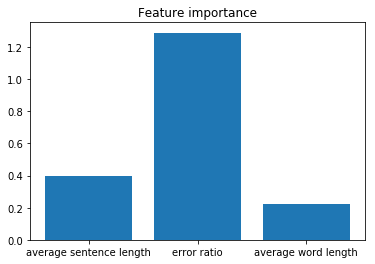

In [26]:
fea = ('average sentence length', 'error ratio', 'average word length')
imp = [0.4,1.29, 0.22]

plt.bar(fea, imp)
plt.title('Feature importance')

plt.show()